In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
#sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10,6)})
# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine.imputation import CategoricalImputer
from sklearn.multiclass import OneVsRestClassifier

# to convert the 1-D target vector in to a matrix
from sklearn.preprocessing import label_binarize

from sklearn.metrics import roc_curve, roc_auc_score

from yellowbrick.classifier import ROCAUC
from sklearn.metrics import (
    roc_auc_score,
    plot_roc_curve,
)

from sklearn.metrics import (
    precision_recall_curve,
    plot_precision_recall_curve,
    average_precision_score,
    auc,
)

from yellowbrick.classifier import PrecisionRecallCurve

# Helper Functions

In [2]:
## Confusion Matrix
def conf_matrix(y_test, col, y_pred):
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_test[col], y_pred)
    cf_norm = cf_matrix.astype("float") / cf_matrix.sum(axis=1)[:, np.newaxis] # normalize it

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = ['({0:.2%})'.format(value) for value in cf_norm.flatten()]
    group_counts = ['Count = {0:0.0f}'.format(value) for value in cf_matrix.flatten()]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, group_counts)]
    labels = np.asarray(labels).reshape(2,2)


    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues') #cmap='binary' #cmap='Blues'

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label")

    plt.show(block=False)

In [3]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
    
      """
      Makes a labelled confusion matrix comparing predictions and ground truth labels.

      If classes is passed, confusion matrix will be labelled, if not, integer class values
      will be used.

      Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).

      Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

      Example usage:
        make_confusion_matrix(y_true=test_labels, # ground truth test labels
                              y_pred=y_preds, # predicted labels
                              classes=class_names, # array of class label names
                              figsize=(15, 15),
                              text_size=10)
      """  
      # Create the confustion matrix
      sns.set_theme(style="white")
      cm = confusion_matrix(y_true, y_pred)
      cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
      n_classes = cm.shape[0] # find the number of classes we're dealing with

      # Plot the figure and make it pretty
      fig, ax = plt.subplots(figsize=figsize)
      cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
      fig.colorbar(cax)

      # Are there a list of classes?
      if classes:
        labels = classes
      else:
        labels = np.arange(cm.shape[0])

      # Label the axes
      ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="True label",
             xticks=np.arange(n_classes), # create enough axis slots for each class
             yticks=np.arange(n_classes), 
             xticklabels=labels, # axes will labeled with class names (if they exist) or ints
             yticklabels=labels)

      # Make x-axis labels appear on bottom
      ax.xaxis.set_label_position("bottom")
      ax.xaxis.tick_bottom()

      # Set the threshold for different colors
      threshold = (cm.max() + cm.min()) / 2.

      # Plot the text on each cell
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

In [4]:
def plot_distribution(data, column):
    plt.figure()
    sns.set(rc={'figure.figsize':(6,4)})
    data[column].value_counts().sort_values(ascending=False).plot.bar()
    plt.xlabel(column)
    plt.ylabel('count')

In [5]:
!pip install openpyxl

# EDA

In [6]:
path = r"C:\Users\yudhi\OneDrive\Desktop\School\Courses\Data_Mining\Data"
os.chdir(path)

In [7]:
#read data in chunks of 1 million rows at a time
df = pd.read_excel('SKDB.xlsx', dtype='object')

df.head(3)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  


,Number,Name,Prison ID,Alias or AKA,Type of Killer,Sex,Race,WhiteMale,WhiteMale20s,NumVics,...,1920,1910,1900,Century,Decade Started,Other information,Nickname,Organizational,Parole Comment,FGCU Record
0,SK05436,"Aal, Mohammed Abdel",NaN,NaN,Serial - Organizational - Gang,1,1,1,NaN,17,...,1,1,0,1900,1910,NaN,NaN,1,NaN,NaN
1,SK05443,"Aataminpoika, Juhani",NaN,NaN,Serial,1,1,1,0,12,...,0,0,0,1800,1840,NaN,NaN,0,NaN,NaN
2,SK00001,"Abbott, Jack Henry",UT 86A005,"Eastman, Jack",Serial - Two murders,1,1,1,0,2,...,0,0,0,1900,1960,NaN,NaN,0,On parole for murder,1


In [8]:
all_killer_cols = ['Name', 'Sex', 'Race', 'NumVics', 'Country', 'US', 'birthyear', 'Age1stKill', 'AgeLastKill', 'Age Group', 'DateFirst', 'DateFinal', 'Victim Code', 'Aamodt Code', 'Aamodt Type', 'Raised', 'Educ', 'Marital Status', 'Sexual Orientation', 'Broad Occupation', 'Previous jail or prison time', 'Kill Method', 'Partner', "LocKilling","YearFirst","YearFinal"]
killer_cols = ['Sex', 'Race', "YearFirst","YearFinal", 'Country','US']
killing_process = ['Sexual Assault', 'Torture', 'Sought victim to kill', 'Overkill', 'Quick', 'Blindfold', 'Bound', 'Mutilate', 'Totem', 'Necrophilia', 'AteBody', 'DrankBlood', 'Posed', 'Body Totem', 'Item Totem']
cleaning_process = ['BodyLeft', 'LeftHidden', 'LeftBuried', 'Moved', 'MovedHide', 'MovedBuried', 'Placed in body of water', 'Body Burned', 'Dismembered', 'TakenHome']
vic_cols = ['VicSex', 'Race of Victim', 'Primary Victim Age']

cols = killing_process + cleaning_process + vic_cols + killer_cols

In [9]:
# Filter necessary columns
data = df[cols]

#Filter necessary date and country
data = data[(data.Country == 'US' ) & (data.US == 1) & (data.YearFirst >= 1976) &(data.YearFinal <= 2020)]
data.head()

,Sexual Assault,Torture,Sought victim to kill,Overkill,Quick,Blindfold,Bound,Mutilate,Totem,Necrophilia,...,TakenHome,VicSex,Race of Victim,Primary Victim Age,Sex,Race,YearFirst,YearFinal,Country,US
4,0,0,1,1,NaN,0,0,0,NaN,0,...,0,1,7,Adults,1,2,2009,2011,US,1
7,1,0,1,0,0,0,0,0,NaN,0,...,0,2,1,Adults,1,1,1982,1993,US,1
9,0,0,1,0,NaN,0,0,0,0,0,...,0,3,1,Elderly,1,1,1983,2010,US,1
10,0,0,1,0,1,0,0,0,0,0,...,0,1,7,Adults,1,3,1991,1992,US,1
11,0,0,0,0,NaN,0,0,0,0,0,...,0,1,2,Adults,1,1,2009,2010,US,1


In [10]:
data.describe()

,Sexual Assault,Torture,Sought victim to kill,Overkill,Quick,Blindfold,Bound,Mutilate,Totem,Necrophilia,...,TakenHome,VicSex,Race of Victim,Primary Victim Age,Sex,Race,YearFirst,YearFinal,Country,US
count,2418,2357,2279,2306,1887,2224,2286,2395,853,2458,...,2402,2444,2374,2441,2481,2470,2481,2481,2481,2481
unique,2,2,3,2,2,2,2,2,3,3,...,2,4,7,7,2,6,45,45,1,1
top,0,0,1,0,0,0,0,0,0,0,...,0,3,1,Adults,1,1,1987,1987,US,1
freq,1692,2131,1868,1917,1439,2193,1891,2266,756,2405,...,2386,978,1027,1948,2330,1114,97,93,2481,2481


In [11]:
# Databse Shape
data.shape

(2481, 34)

In [12]:
# Get total of missing values for each variable
data.isnull().sum()

Sexual Assault               63
Torture                     124
Sought victim to kill       202
Overkill                    175
Quick                       594
Blindfold                   257
Bound                       195
Mutilate                     86
Totem                      1628
Necrophilia                  23
AteBody                      21
DrankBlood                   21
Posed                        31
Body Totem                   32
Item Totem                 2045
BodyLeft                     84
LeftHidden                  100
LeftBuried                   81
Moved                        99
MovedHide                    98
MovedBuried                  83
Placed in body of water     212
Body Burned                 205
Dismembered                  74
TakenHome                    79
VicSex                       37
Race of Victim              107
Primary Victim Age           40
Sex                           0
Race                         11
YearFirst                     0
YearFina

In [13]:
# The average missing values in each variable
data.isnull().mean()

Sexual Assault             0.025393
Torture                    0.049980
Sought victim to kill      0.081419
Overkill                   0.070536
Quick                      0.239420
Blindfold                  0.103587
Bound                      0.078597
Mutilate                   0.034663
Totem                      0.656187
Necrophilia                0.009270
AteBody                    0.008464
DrankBlood                 0.008464
Posed                      0.012495
Body Totem                 0.012898
Item Totem                 0.824264
BodyLeft                   0.033857
LeftHidden                 0.040306
LeftBuried                 0.032648
Moved                      0.039903
MovedHide                  0.039500
MovedBuried                0.033454
Placed in body of water    0.085449
Body Burned                0.082628
Dismembered                0.029827
TakenHome                  0.031842
VicSex                     0.014913
Race of Victim             0.043128
Primary Victim Age         0

#### Variables with > 5% but < 10% missing data: "Sought victim to kill", "Overkill", "Bound", "Placed in body of water", "Body Burned"

#### Variables with >= 10% missing data: "Quick", "Blindfold", "Totem", "Item Totem"

## Data Cleaning: Delete Wrong-Value Rows

In [14]:
# Dropping wrong label rows
i = data[df.VicSex == 7.0].index
data.drop(i, inplace=True)

i = data[data['Necrophilia']=='?'].index
data.drop(i, inplace=True)

i = data[data['Sought victim to kill']==' '].index
data.drop(i, inplace=True)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [15]:
# # remove rows where target is null (MICE as alternative for imputation in targets)
# print("Before = ", data.shape)
# data.dropna(subset=['Sex', 'Race'], axis=0, inplace=True)
# print("After = ", data.shape)

In [16]:
data.isnull().mean()

Sexual Assault             0.025424
Torture                    0.050040
Sought victim to kill      0.081517
Overkill                   0.070621
Quick                      0.239709
Blindfold                  0.103309
Bound                      0.078692
Mutilate                   0.034705
Totem                      0.656174
Necrophilia                0.009282
AteBody                    0.008475
DrankBlood                 0.008475
Posed                      0.012107
Body Totem                 0.012914
Item Totem                 0.824052
BodyLeft                   0.033898
LeftHidden                 0.040355
LeftBuried                 0.032688
Moved                      0.039952
MovedHide                  0.039548
MovedBuried                0.033495
Placed in body of water    0.085553
Body Burned                0.082728
Dismembered                0.029863
TakenHome                  0.031477
VicSex                     0.014931
Race of Victim             0.043180
Primary Victim Age         0

# Victims

In [17]:
data.columns[:-3]

Index(['Sexual Assault', 'Torture', 'Sought victim to kill', 'Overkill',
       'Quick', 'Blindfold', 'Bound', 'Mutilate', 'Totem', 'Necrophilia',
       'AteBody', 'DrankBlood', 'Posed', 'Body Totem', 'Item Totem',
       'BodyLeft', 'LeftHidden', 'LeftBuried', 'Moved', 'MovedHide',
       'MovedBuried', 'Placed in body of water', 'Body Burned', 'Dismembered',
       'TakenHome', 'VicSex', 'Race of Victim', 'Primary Victim Age', 'Sex',
       'Race', 'YearFirst'],
      dtype='object')

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


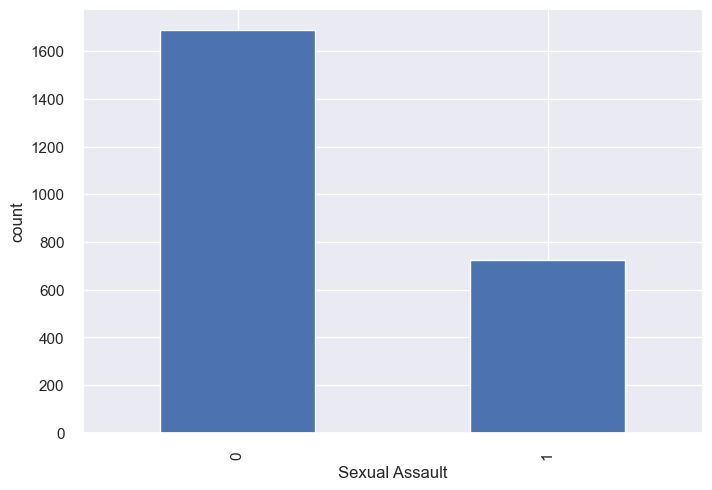

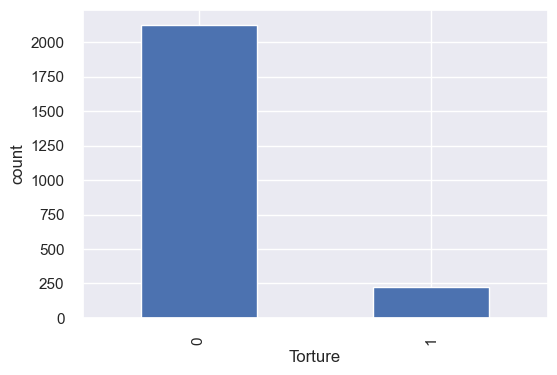

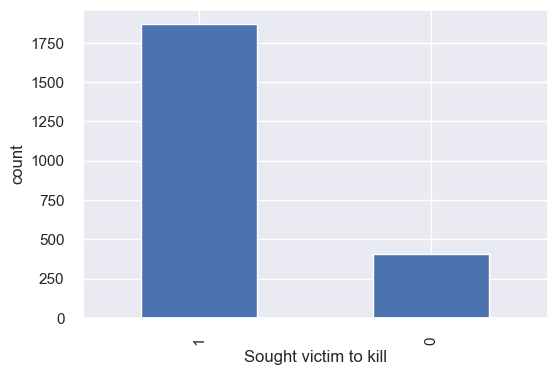

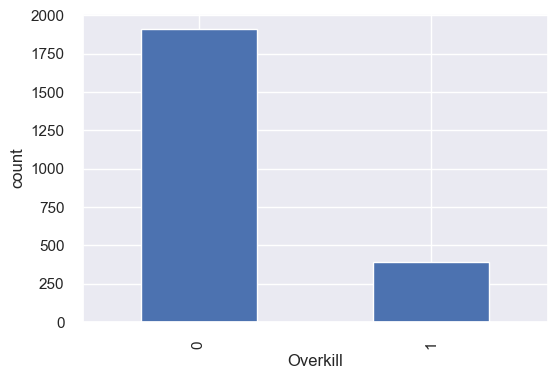

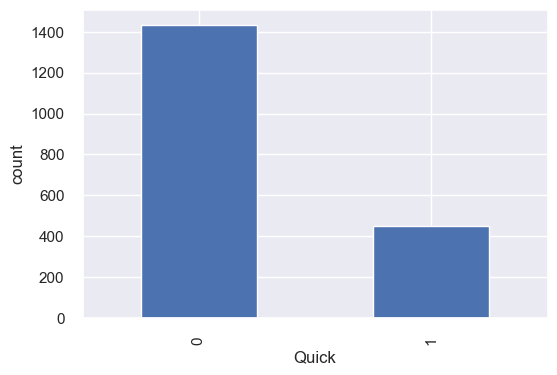

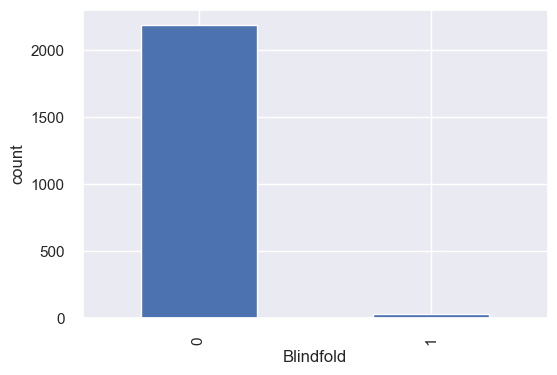

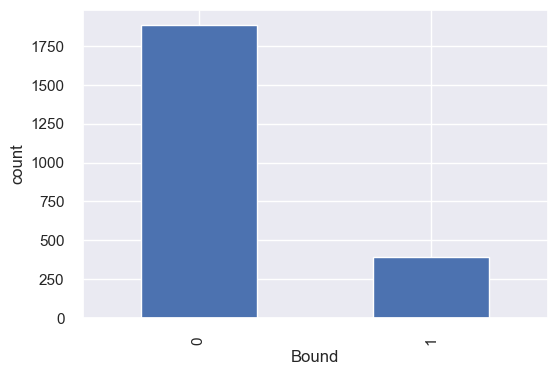

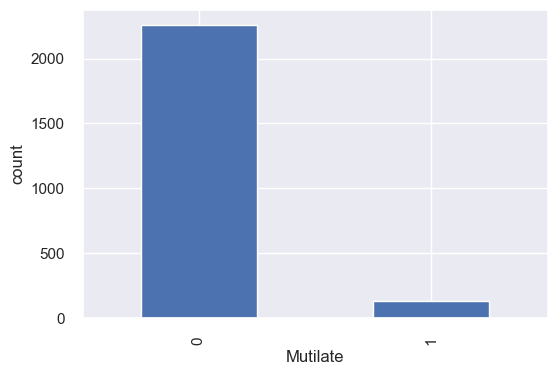

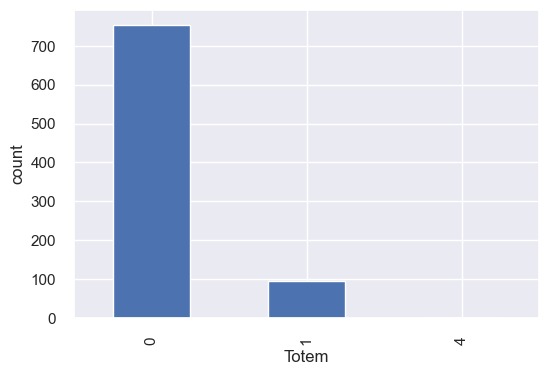

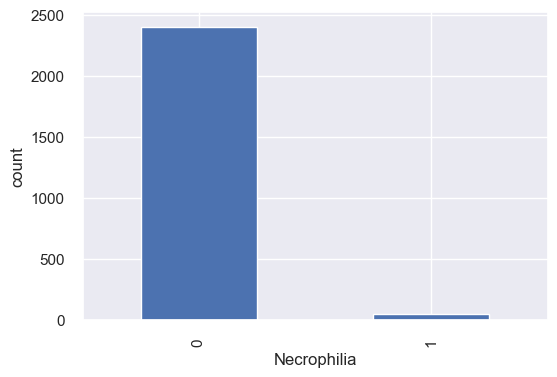

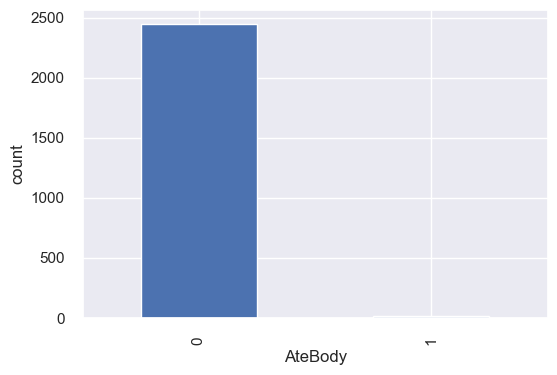

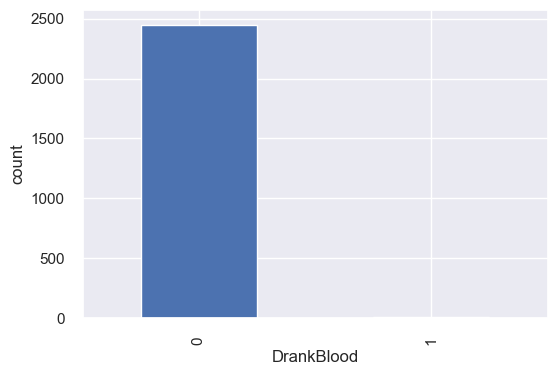

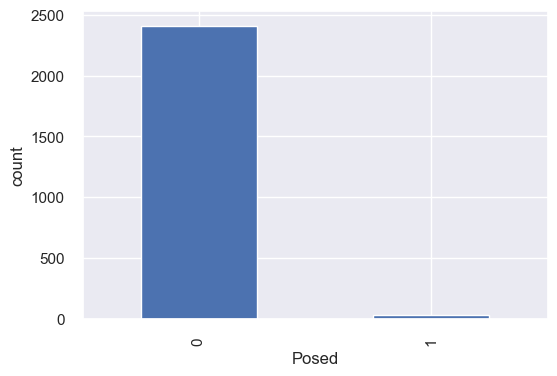

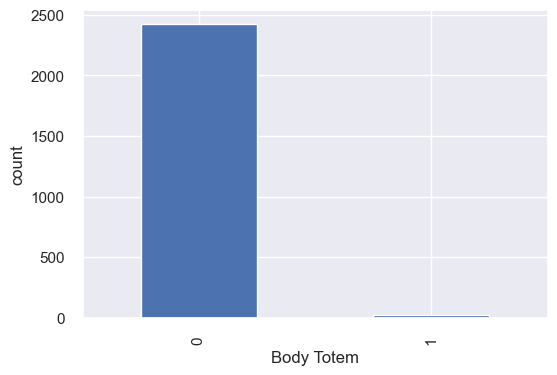

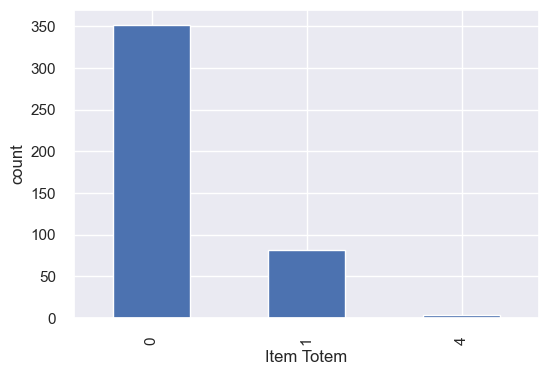

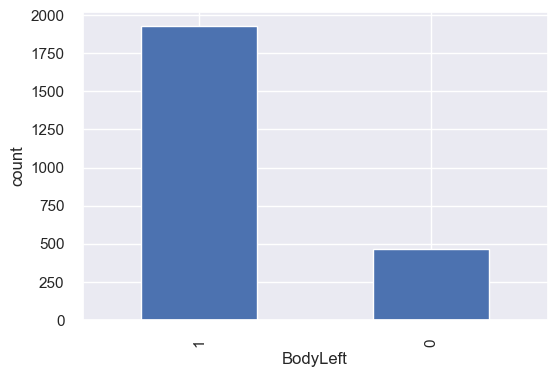

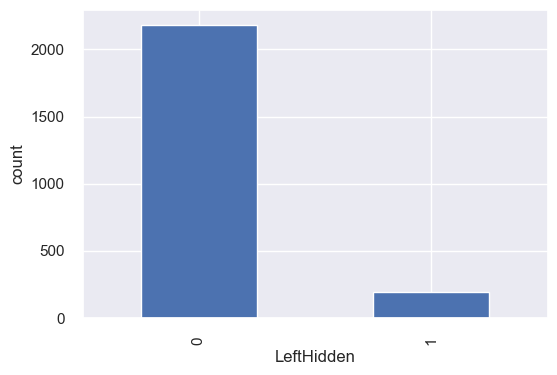

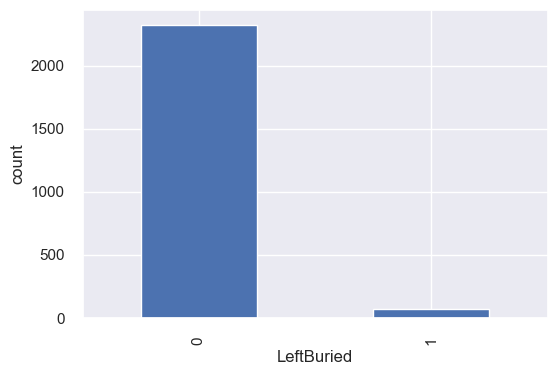

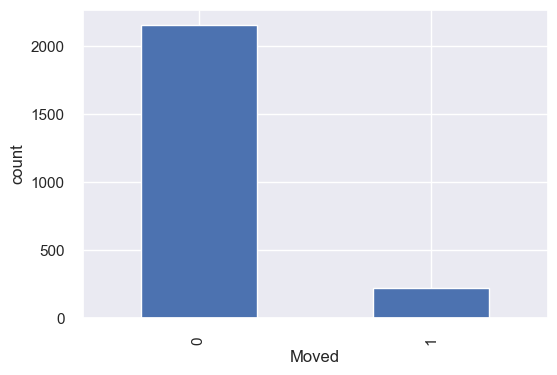

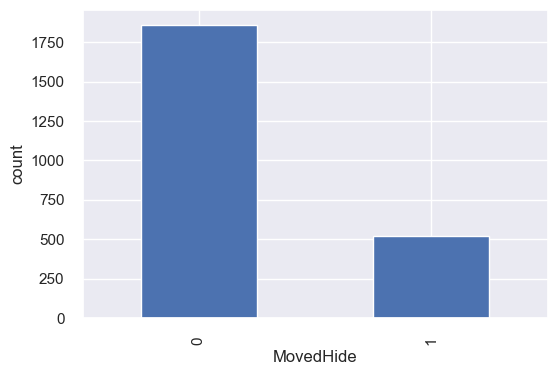

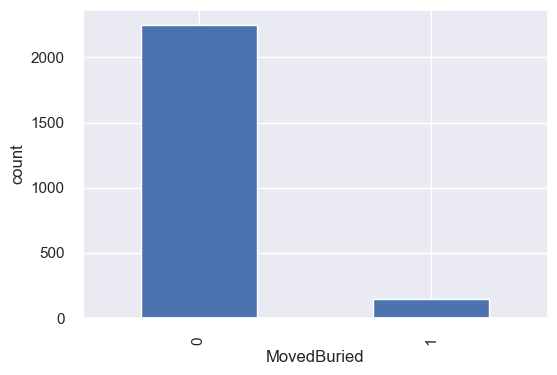

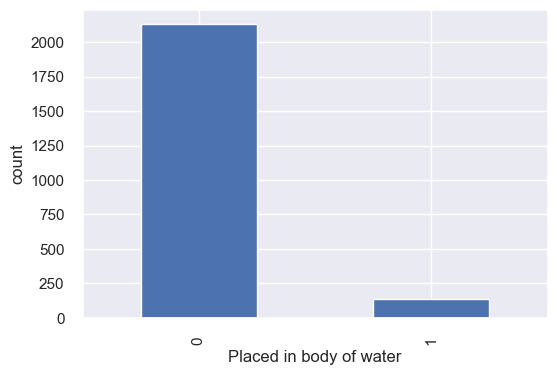

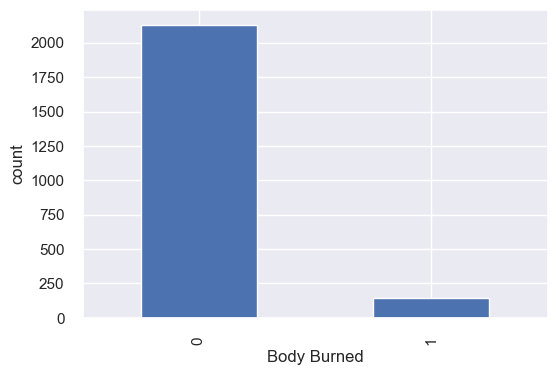

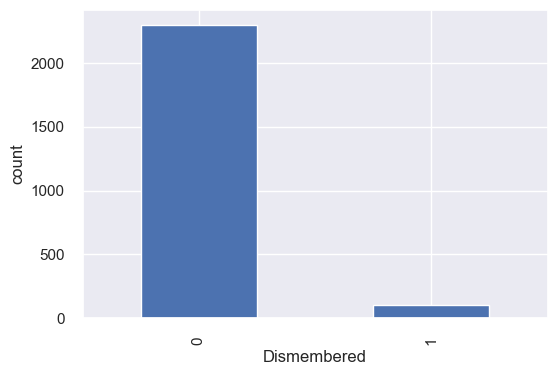

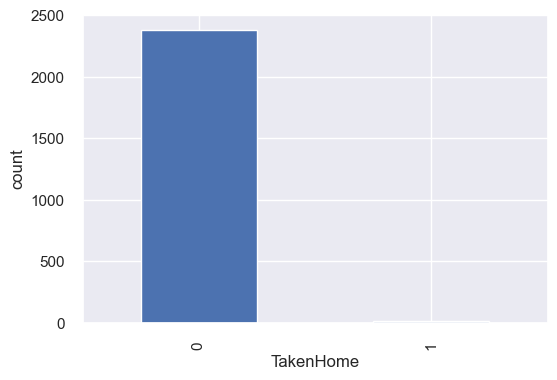

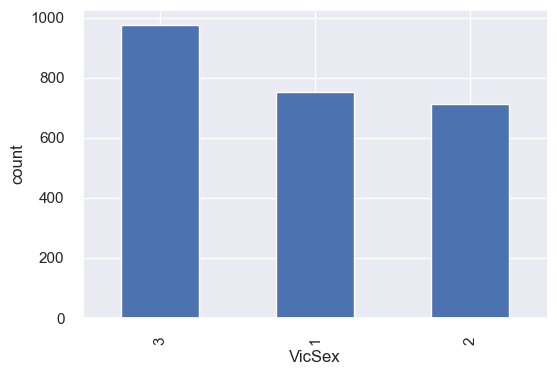

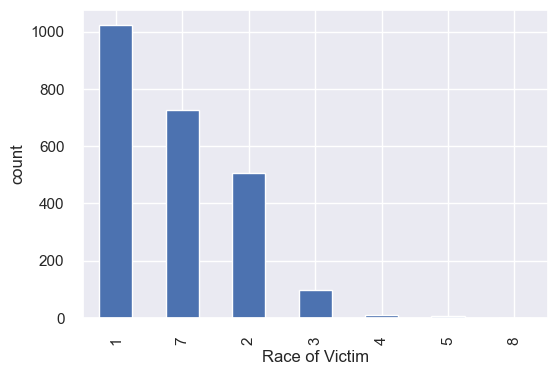

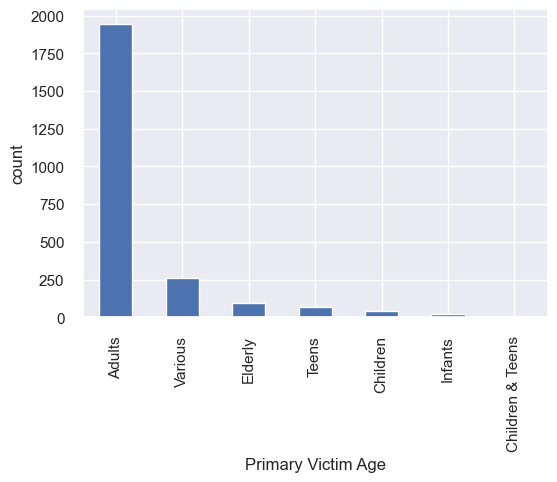

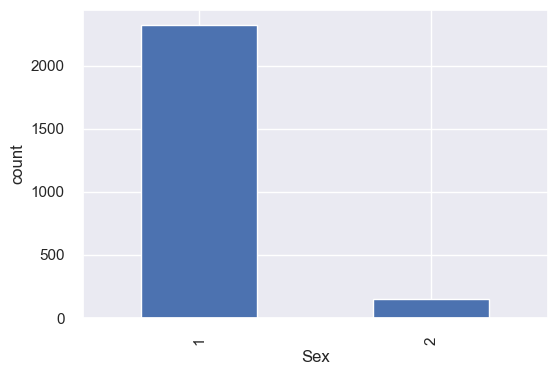

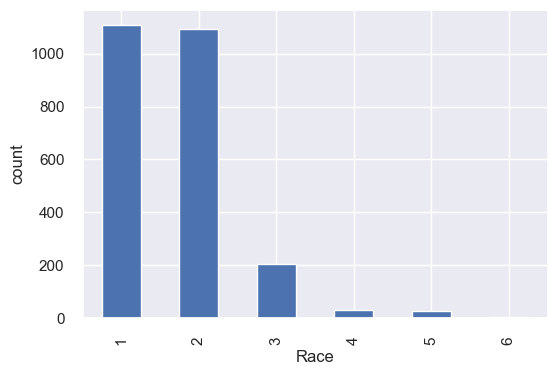

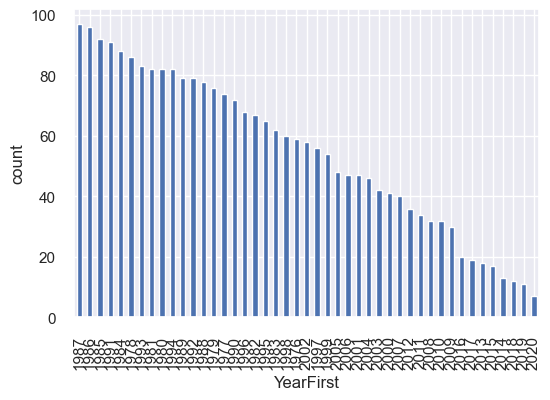

In [18]:
for i in data.columns[:-3]:
    plot_distribution(data, i)

# Killer

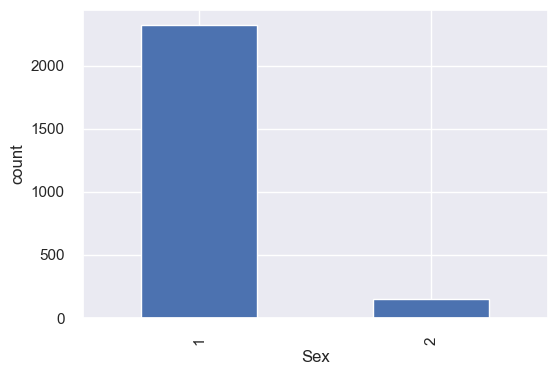

In [19]:
# We have way more males than females
plot_distribution(data, 'Sex')

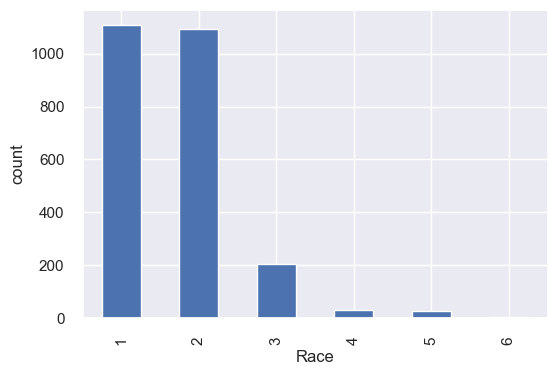

In [20]:
plot_distribution(data, 'Race')

In [21]:
# plot_distribution(data, 'Age Group')

# Group Race

In [22]:
data['Race'].value_counts()

1    1111
2    1095
3     205
4      29
5      25
6       2
Name: Race, dtype: int64

In [23]:
# We combine race 4, 5, 6 into group 4
data['Race'] = data['Race'].map({1: 0, 2: 1, 3: 2, 4: 3, 5: 3, 6: 3}).astype('object')

In [24]:
# We combine race 4, 5, 6 into group 4
data['Sex'] = data['Sex'].map({1: 0, 2: 1}).astype('object')

In [25]:
# # We combine race 4, 5, 6 into group 4
# data['Age Group'] = data['Age Group'].map({10: 0, 20: 1, 30:2, 40:3, 50:4, 60:5, 70:6}).astype('object')
# data['Age Group'].value_counts()

In [26]:
data['Sex'].value_counts()

0    2327
1     151
Name: Sex, dtype: int64

In [27]:
data['Race'].value_counts()

0.0    1111
1.0    1095
2.0     205
3.0      56
Name: Race, dtype: int64

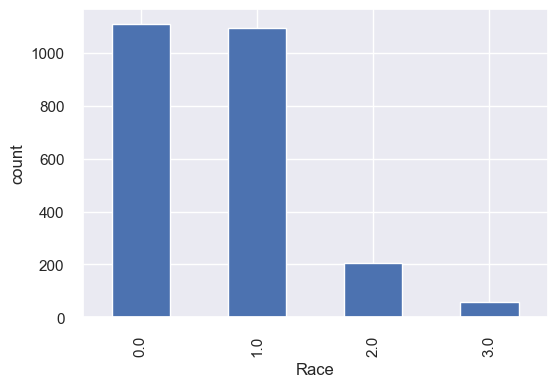

In [28]:
plot_distribution(data, 'Race')

# Train-Test Split

In [29]:
data.shape

(2478, 34)

In [30]:
data.drop(['US', 'Country',"YearFirst","YearFinal"], axis=1, inplace=True)
# Drop Totem and Item Totem columns because > 50% missing data
data.drop(['Totem', 'Item Totem'], axis=1, inplace=True)

# separate into training and testing set
n_test = 2
X = data[data.columns[:-n_test]]
y = data[['Sex', 'Race']]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1734, 26), (744, 26))

In [31]:
X_train.columns

Index(['Sexual Assault', 'Torture', 'Sought victim to kill', 'Overkill',
       'Quick', 'Blindfold', 'Bound', 'Mutilate', 'Necrophilia', 'AteBody',
       'DrankBlood', 'Posed', 'Body Totem', 'BodyLeft', 'LeftHidden',
       'LeftBuried', 'Moved', 'MovedHide', 'MovedBuried',
       'Placed in body of water', 'Body Burned', 'Dismembered', 'TakenHome',
       'VicSex', 'Race of Victim', 'Primary Victim Age'],
      dtype='object')

In [32]:
print("Done")

Done


# Data Imputation

In [33]:
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)

In [34]:
def imputation(model, X_train, X_test, y_train, y_test):
    
    print("Model name = ", model)
    print("Before = ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    if model == 'frequent':
        imputer = CategoricalImputer(imputation_method='frequent')
        imputer.fit(X_train)
        X_train = imputer.transform(X_train)
        X_test = imputer.transform(X_test)
        
    elif model == 'AddMissingIndicator':
        pipe = Pipeline([
            ('missing_ind', AddMissingIndicator()),

            ('imputer_mode', CategoricalImputer(
                imputation_method='frequent'))])
        
        # fit the pipe
        pipe.fit(X_train)
        X_train = pipe.transform(X_train)
        X_test = pipe.transform(X_test)
        
    else:
        print("Error!")
    
    #Impute labels using Frequent Category Imputation
    imputer = CategoricalImputer(imputation_method='frequent')
    imputer.fit(y_train)
    y_train = imputer.transform(y_train)
    y_test = imputer.transform(y_test)
    # y_train = y_train
    # y_test = y_test
    
    print("After = ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test
        

In [35]:
# model = frequent or AddMissingIndicator
xx_train, xx_test, yy_train, yy_test = imputation(model='frequent', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Model name =  frequent
Before =  (1734, 26) (744, 26) (1734, 2) (744, 2)
After =  (1734, 26) (744, 26) (1734, 2) (744, 2)


In [36]:
xx_train.isnull().mean()

Sexual Assault             0.0
Torture                    0.0
Sought victim to kill      0.0
Overkill                   0.0
Quick                      0.0
Blindfold                  0.0
Bound                      0.0
Mutilate                   0.0
Necrophilia                0.0
AteBody                    0.0
DrankBlood                 0.0
Posed                      0.0
Body Totem                 0.0
BodyLeft                   0.0
LeftHidden                 0.0
LeftBuried                 0.0
Moved                      0.0
MovedHide                  0.0
MovedBuried                0.0
Placed in body of water    0.0
Body Burned                0.0
Dismembered                0.0
TakenHome                  0.0
VicSex                     0.0
Race of Victim             0.0
Primary Victim Age         0.0
dtype: float64

In [37]:
xx_test.isnull().mean()

Sexual Assault             0.0
Torture                    0.0
Sought victim to kill      0.0
Overkill                   0.0
Quick                      0.0
Blindfold                  0.0
Bound                      0.0
Mutilate                   0.0
Necrophilia                0.0
AteBody                    0.0
DrankBlood                 0.0
Posed                      0.0
Body Totem                 0.0
BodyLeft                   0.0
LeftHidden                 0.0
LeftBuried                 0.0
Moved                      0.0
MovedHide                  0.0
MovedBuried                0.0
Placed in body of water    0.0
Body Burned                0.0
Dismembered                0.0
TakenHome                  0.0
VicSex                     0.0
Race of Victim             0.0
Primary Victim Age         0.0
dtype: float64

In [38]:
yy_train.isnull().mean()

Sex     0.0
Race    0.0
dtype: float64

In [39]:
yy_test.isnull().mean()

Sex     0.0
Race    0.0
dtype: float64

In [40]:
print("Done")

Done


# Categorical Encoding

In [41]:
# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder
from feature_engine.encoding import RareLabelEncoder

In [42]:
'''
Categorical Encoding Function
'''
def cat_encoding(model, col, X_train, X_test, tolerance=None, n_categories=None, drop_last=True):
    
        print("Categorical encoding model = ", model)
        print("Before = ", X_train.shape, X_test.shape)
        
        if model == 'fe_OneHotEncoder':
            ohe_enc = fe_OneHotEncoder(
            top_categories=None,
            variables=[col],  # select which variables to encode
            drop_last=drop_last)  # to return k-1, false to return k
        
        elif model == 'RareLabelEncoder':

            # Rare value encoder
            rare_encoder = RareLabelEncoder(
            tol=tolerance,  # minimal percentage to be considered non-rare
            n_categories=n_categories, # minimal number of categories the variable should have to re-cgroup rare categories
            variables=[col]) # variables to re-group
            
            rare_encoder.fit(X_train.fillna('Missing'))
            X_train = rare_encoder.transform(X_train.fillna('Missing'))
            X_test = rare_encoder.transform(X_test.fillna('Missing'))
            
            # Visualize variables with high cardinality but low number of samples
            for col in [col]: #'Race of Victim', 

                temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )
                # make plot with the above percentages
                fig = temp_df.sort_values(ascending=False).plot.bar()
                fig.set_xlabel(col)
                # add a line at 5 % to flag the threshold for rare categories
                fig.axhline(y=0.05, color='red')
                fig.set_ylabel('Percentage')
                plt.show()
                
            ohe_enc = fe_OneHotEncoder(
            top_categories=None,
            variables=[col],  # select which variables to encode
            drop_last=drop_last)  # to return k-1, false to return k
            
        else:
            print("Error!")
            
        # Fit encoder
        ohe_enc.fit(X_train.fillna('Missing'))

        # Transform Encoder
        X_train = ohe_enc.transform(X_train.fillna('Missing'))
        X_test = ohe_enc.transform(X_test.fillna('Missing'))

        print("After = ", X_train.shape, X_test.shape)
        return X_train, X_test


Categorical encoding model =  RareLabelEncoder
Before =  (1734, 26) (744, 26)


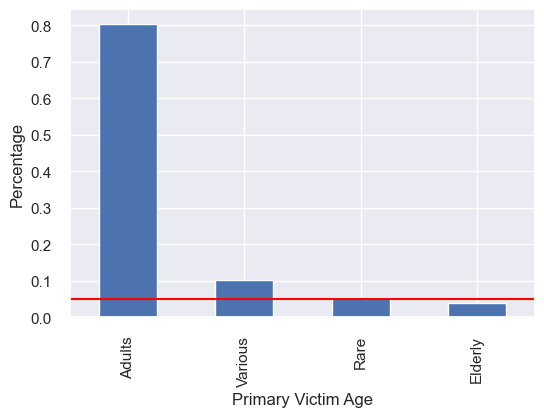

After =  (1734, 28) (744, 28)


In [43]:
#model = RareLabelEncoder  OR fe_OneHotEncoder
xx_train, xx_test = cat_encoding(model='RareLabelEncoder', col='Primary Victim Age', X_train=xx_train, X_test=xx_test, tolerance=0.03, n_categories=4, drop_last=True) 

In [44]:
xx_train.head(2)

,Sexual Assault,Torture,Sought victim to kill,Overkill,Quick,Blindfold,Bound,Mutilate,Necrophilia,AteBody,...,MovedBuried,Placed in body of water,Body Burned,Dismembered,TakenHome,VicSex,Race of Victim,Primary Victim Age_Adults,Primary Victim Age_Elderly,Primary Victim Age_Various
1292,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,3,1,1,0,0
3805,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,1,0,0


In [45]:
print("Done")

Done


## Concat

In [46]:
# Concat training and testng data for stratified train_test split

xx_train.shape, yy_train.shape, xx_test.shape, yy_test.shape

upper = xx_train.join(yy_train)
upper.shape

lower = xx_test.join(yy_test)
lower.shape

df = pd.concat([upper, lower], axis=0)
df.shape

df.head()

,Sexual Assault,Torture,Sought victim to kill,Overkill,Quick,Blindfold,Bound,Mutilate,Necrophilia,AteBody,...,Body Burned,Dismembered,TakenHome,VicSex,Race of Victim,Primary Victim Age_Adults,Primary Victim Age_Elderly,Primary Victim Age_Various,Sex,Race
1292,0,0,1,0,1,0,0,0,0,0,...,0,0,0,3,1,1,0,0,0,1.0
3805,1,1,0,0,0,0,0,0,0,0,...,0,0,0,2,1,1,0,0,0,0.0
2274,1,0,0,0,0,0,0,0,0,0,...,0,0,0,3,3,1,0,0,0,1.0
3232,0,0,1,0,1,0,0,0,0,0,...,0,0,0,3,1,0,1,0,1,0.0
3601,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,1.0


In [47]:
# df.to_csv('output.csv', index=False)  

In [48]:
print("Done")

Done


# Predicting Sex

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [50]:
'''
Run this cell before running any prediction for Sex
'''

# separate into training and testing set
n_test = 2
X = df[df.columns[:-n_test]]
y = df[['Sex']]
xx_train,xx_test, yy_train, yy_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state=0)

In [51]:
xx_train.shape, yy_train.shape, xx_test.shape, yy_test.shape

((1734, 28), (1734, 1), (744, 28), (744, 1))

In [52]:
print("Done")

Done


In [53]:
yy_test.value_counts(normalize=True)

Sex
0      0.939516
1      0.060484
dtype: float64

In [54]:
yy_train.value_counts(normalize=True)

Sex
0      0.93887
1      0.06113
dtype: float64

In [55]:
yy_train.value_counts()

Sex
0      1628
1       106
dtype: int64

In [56]:
from sklearn.utils.multiclass import type_of_target
type_of_target(yy_test)

'binary'

## Random Forest

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler

### Decision Tree Classifier with and without SMOTE

Without SMOTE: 

Train Mean ROC AUC: 0.674
Test Mean ROC AUC: 0.624
Test Accuracy: 0.9301075268817204
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       699
           1       0.32      0.13      0.19        45

    accuracy                           0.93       744
   macro avg       0.63      0.56      0.58       744
weighted avg       0.91      0.93      0.92       744



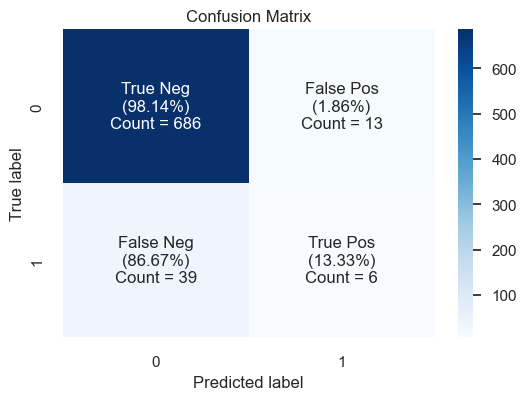

SMOTE: 

Train Mean ROC AUC: 0.675
Test Mean ROC AUC: 0.615
Test Accuracy: 0.8225806451612904
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       699
           1       0.15      0.42      0.22        45

    accuracy                           0.82       744
   macro avg       0.55      0.64      0.56       744
weighted avg       0.91      0.82      0.86       744



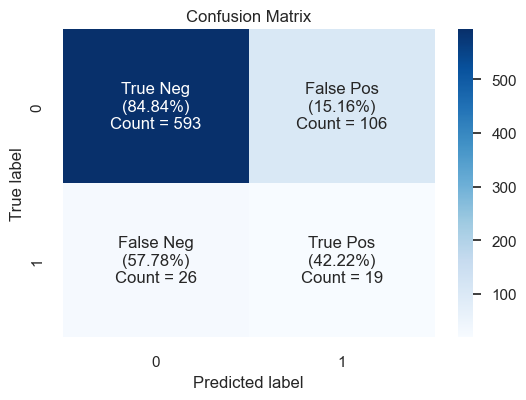

In [58]:
print("Without SMOTE: \n")
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_test = cross_val_score(model, xx_test, yy_test, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))
print('Test Mean ROC AUC: %.3f' % mean(scores_test))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

dtc = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', dtc)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % mean(scores))
scores_train = cross_val_score(dtc, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_test = cross_val_score(dtc, xx_test, yy_test, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))
print('Test Mean ROC AUC: %.3f' % mean(scores_test))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


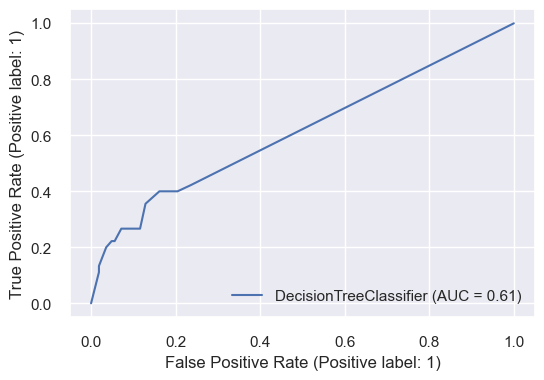

In [59]:
dtc_disp = plot_roc_curve(model, xx_test, yy_test)

### Random Forest Classifier with and without SMOTE

In [60]:
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200, 500, 1000]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(xx_train, yy_train['Sex'])
#save best model
rf_best_sex = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
n_estimators = rf_gs.best_params_.get('n_estimators')

{'n_estimators': 500}


Without SMOTE: 

Mean ROC AUC: 0.788
Accuracy: 0.9422043010752689
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       699
           1       0.58      0.16      0.25        45

    accuracy                           0.94       744
   macro avg       0.77      0.57      0.61       744
weighted avg       0.93      0.94      0.93       744



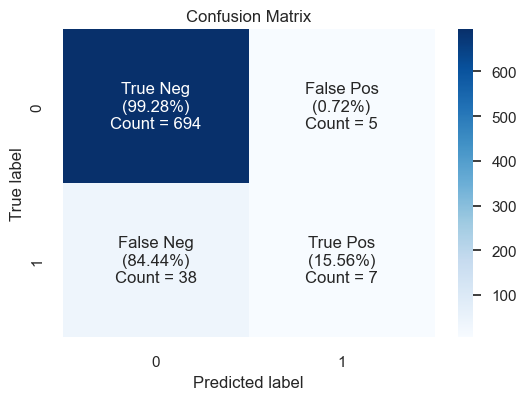

SMOTE: 

Mean ROC AUC: 0.782
Accuracy: 0.8467741935483871
              precision    recall  f1-score   support

           0       0.95      0.88      0.92       699
           1       0.13      0.27      0.17        45

    accuracy                           0.85       744
   macro avg       0.54      0.58      0.54       744
weighted avg       0.90      0.85      0.87       744



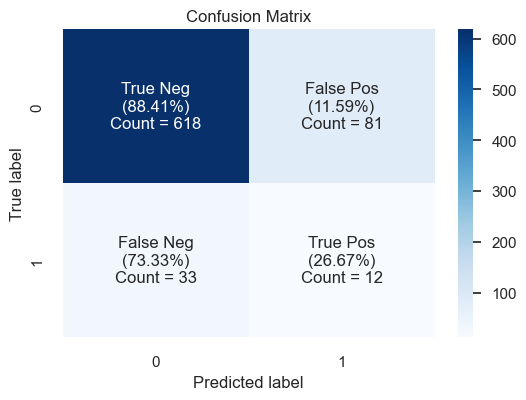

In [61]:
print("Without SMOTE: \n")
# define model
model = RandomForestClassifier(n_estimators = n_estimators, random_state = 42)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

# define pipeline
print("SMOTE: \n")

rf = RandomForestClassifier(n_estimators = n_estimators, random_state = 42)
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', rf)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


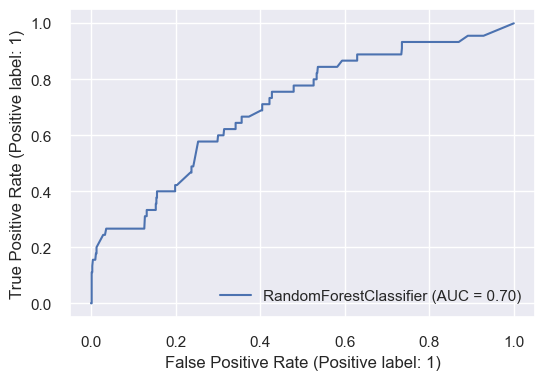

In [62]:
rf_disp = plot_roc_curve(rf, xx_test, yy_test)

### Simple Random Forest

In [63]:
# Instantiate model with 1000 decision trees
rf_sex = RandomForestClassifier(n_estimators = n_estimators, random_state = 42)
# Train the model on training data
rf_sex.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = rf_sex.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

Accuracy: 0.9422043010752689


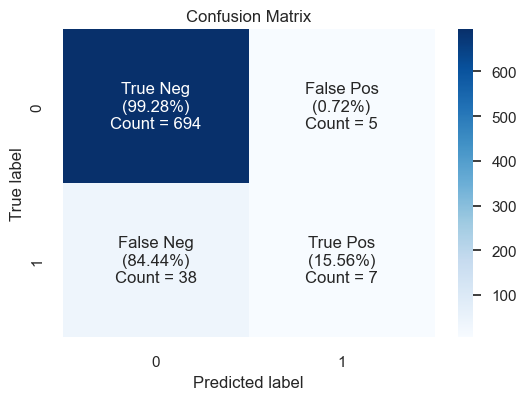

In [64]:
conf_matrix(yy_test, 'Sex', yy_pred)

## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

### Simple Logistic Regression

In [66]:
# all parameters not specified are set to their defaults
log_reg_sex = LogisticRegression(random_state=42)
log_reg_sex.fit(xx_train, yy_train['Sex'])
yy_pred = log_reg_sex.predict(xx_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))

Accuracy: 0.9408602150537635
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       699
           1       1.00      0.02      0.04        45

    accuracy                           0.94       744
   macro avg       0.97      0.51      0.51       744
weighted avg       0.94      0.94      0.91       744



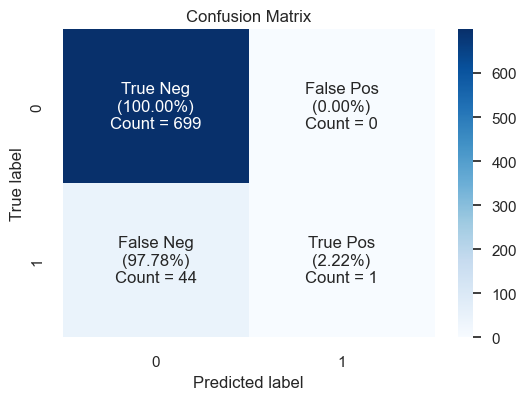

In [67]:
conf_matrix(yy_test, 'Sex', yy_pred)

### Logistic Regression with and without SMOTE

Without SMOTE: 

Mean ROC AUC: 0.775
Accuracy: 0.9408602150537635
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       699
           1       1.00      0.02      0.04        45

    accuracy                           0.94       744
   macro avg       0.97      0.51      0.51       744
weighted avg       0.94      0.94      0.91       744



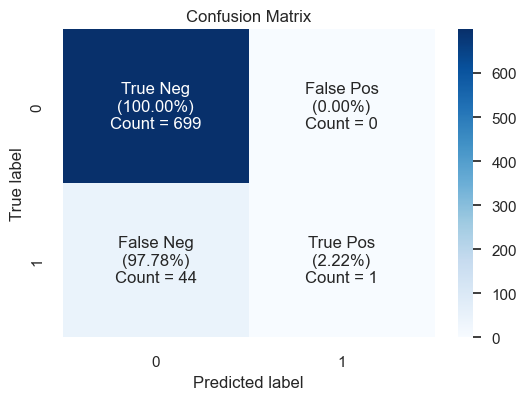

SMOTE: 

Mean ROC AUC: 0.773
Accuracy: 0.8830645161290323
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       699
           1       0.24      0.44      0.31        45

    accuracy                           0.88       744
   macro avg       0.60      0.68      0.63       744
weighted avg       0.92      0.88      0.90       744



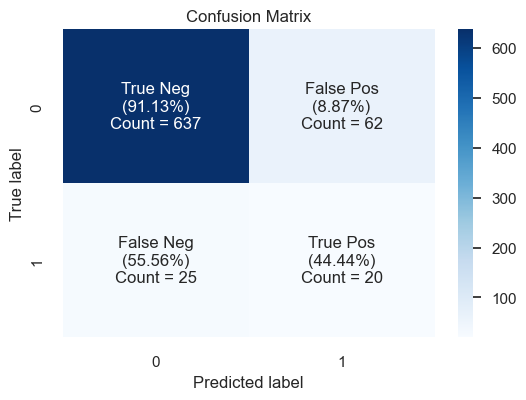

In [68]:
print("Without SMOTE: \n")
# define model
model = LogisticRegression()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

logit = LogisticRegression()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', logit)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


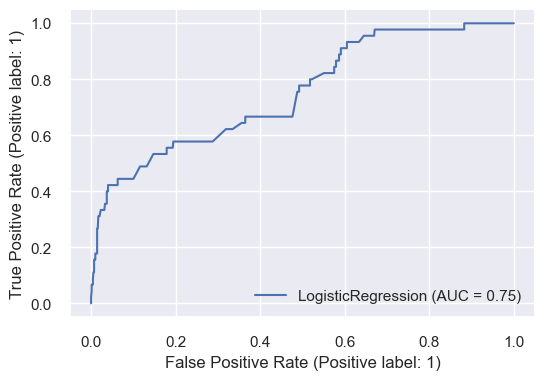

In [69]:
logit_disp = plot_roc_curve(logit, xx_test, yy_test)

## AdaBoost

In [70]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

### Simple AdaBoost

In [71]:
# Instantiate model with 1000 decision trees
ada_sex = AdaBoostClassifier(n_estimators = 100, random_state = 42)
# Train the model on training data
ada_sex.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = ada_sex.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

Accuracy: 0.946236559139785


#### AdaBoost with and without SMOTE

Without SMOTE: 

Mean ROC AUC: 0.804
Accuracy: 0.9448924731182796
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       699
           1       0.83      0.11      0.20        45

    accuracy                           0.94       744
   macro avg       0.89      0.55      0.58       744
weighted avg       0.94      0.94      0.92       744



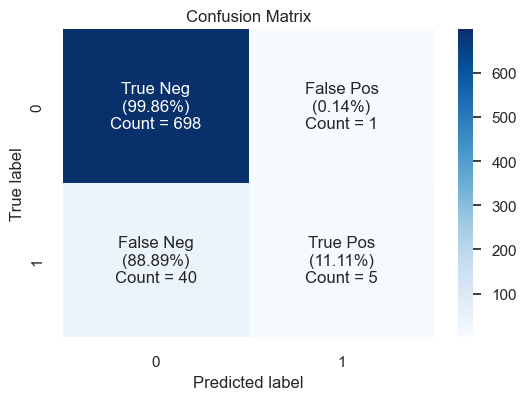

SMOTE: 

Mean ROC AUC: 0.798
Accuracy: 0.8494623655913979
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       699
           1       0.19      0.47      0.27        45

    accuracy                           0.85       744
   macro avg       0.58      0.67      0.59       744
weighted avg       0.92      0.85      0.88       744



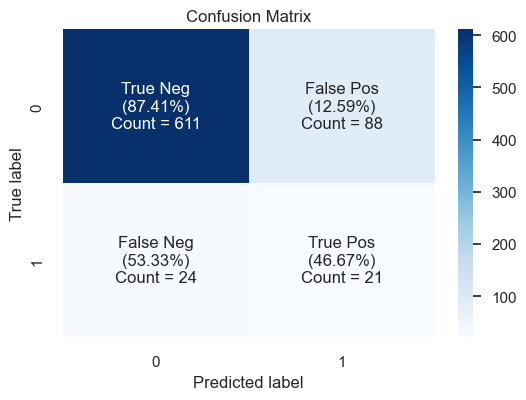

In [72]:
print("Without SMOTE: \n")
# define model
model = AdaBoostClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

ada = AdaBoostClassifier()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', ada)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


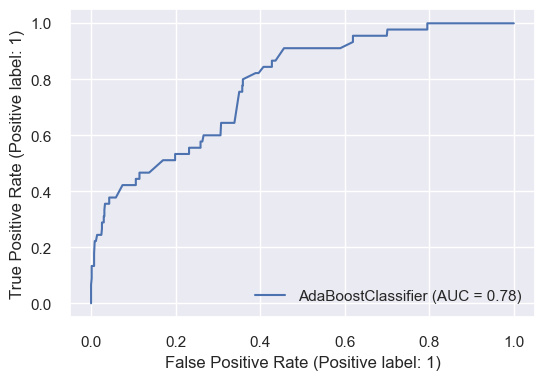

In [73]:
ada_disp = plot_roc_curve(ada, xx_test, yy_test)

## XGBoost

In [74]:
from xgboost import XGBClassifier

Without SMOTE: 

Mean ROC AUC: 0.800
Accuracy: 0.9381720430107527
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       699
           1       0.46      0.13      0.21        45

    accuracy                           0.94       744
   macro avg       0.70      0.56      0.59       744
weighted avg       0.92      0.94      0.92       744



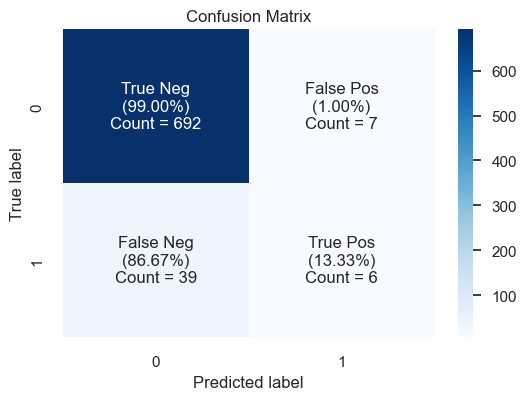

SMOTE: 

Mean ROC AUC: 0.767
Accuracy: 0.8481182795698925
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       699
           1       0.19      0.47      0.27        45

    accuracy                           0.85       744
   macro avg       0.58      0.67      0.59       744
weighted avg       0.92      0.85      0.88       744



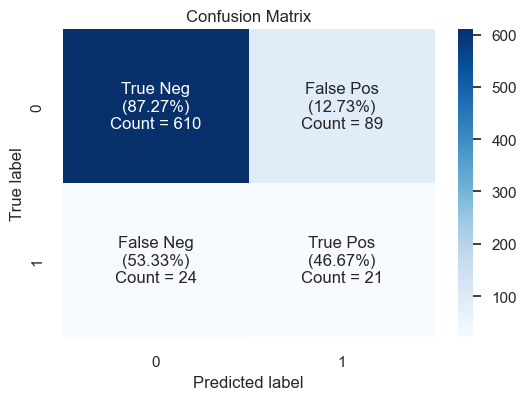

In [75]:
print("Without SMOTE: \n")
# define model
model = XGBClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

xg = XGBClassifier()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', xg)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


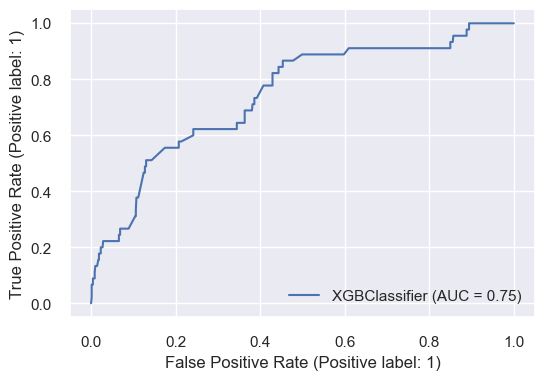

In [76]:
xg_disp = plot_roc_curve(xg, xx_test, yy_test)

## KNN

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

### Simple KNN

In [78]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(xx_train, yy_train['Sex'])

#save best model
knn_best_sex = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)
n_neighbors = knn_gs.best_params_.get('n_neighbors')

{'n_neighbors': 10}


In [79]:
knn_sex = KNeighborsClassifier(n_neighbors=n_neighbors)

# Train the model on training data
knn_sex.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = knn_sex.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

Accuracy: 0.9408602150537635


### KNN with and Without SMOTE

Without SMOTE: 

Mean ROC AUC: 0.723
Accuracy: 0.9408602150537635
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       699
           1       1.00      0.02      0.04        45

    accuracy                           0.94       744
   macro avg       0.97      0.51      0.51       744
weighted avg       0.94      0.94      0.91       744



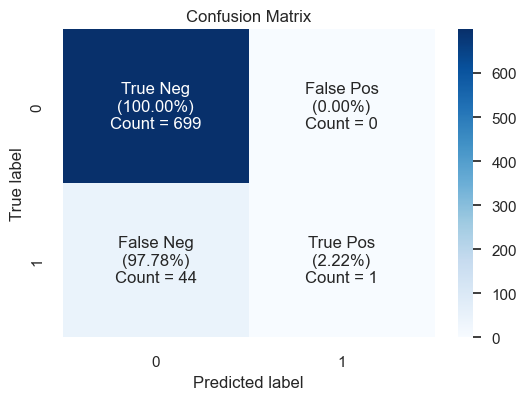

SMOTE: 

Mean ROC AUC: 0.741
Accuracy: 0.8266129032258065
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       699
           1       0.18      0.51      0.26        45

    accuracy                           0.83       744
   macro avg       0.57      0.68      0.58       744
weighted avg       0.92      0.83      0.86       744



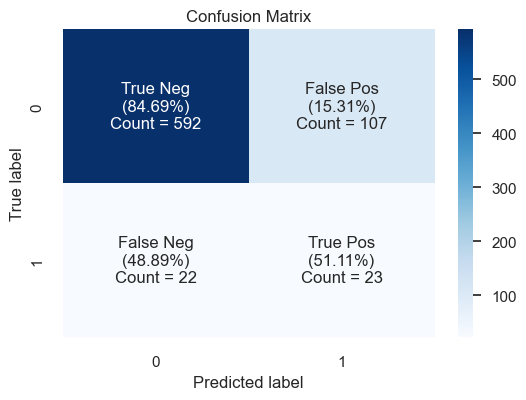

In [80]:
print("Without SMOTE: \n")
# define model
model = KNeighborsClassifier(n_neighbors=n_neighbors)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

knn = KNeighborsClassifier()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', knn)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


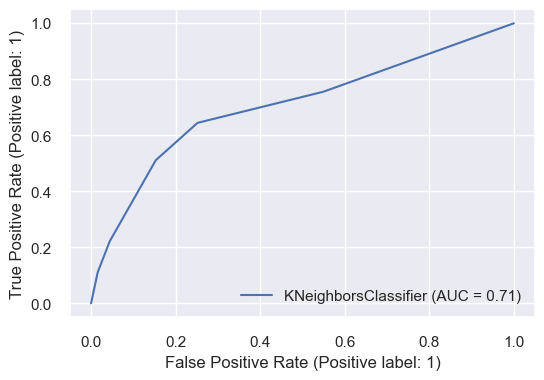

In [81]:
knn_disp = plot_roc_curve(knn, xx_test, yy_test)

## SVM

In [82]:
# import SVC classifier
from sklearn import svm

Without SMOTE: 

Mean ROC AUC: 0.767
Accuracy: 0.9395161290322581
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       699
           1       0.00      0.00      0.00        45

    accuracy                           0.94       744
   macro avg       0.47      0.50      0.48       744
weighted avg       0.88      0.94      0.91       744



C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


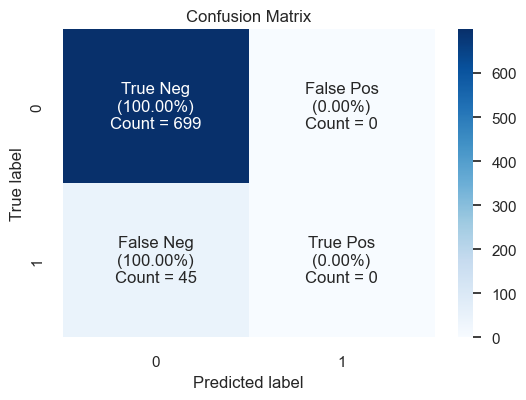

SMOTE: 

Mean ROC AUC: 0.781
Accuracy: 0.8884408602150538
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       699
           1       0.24      0.40      0.30        45

    accuracy                           0.89       744
   macro avg       0.60      0.66      0.62       744
weighted avg       0.92      0.89      0.90       744



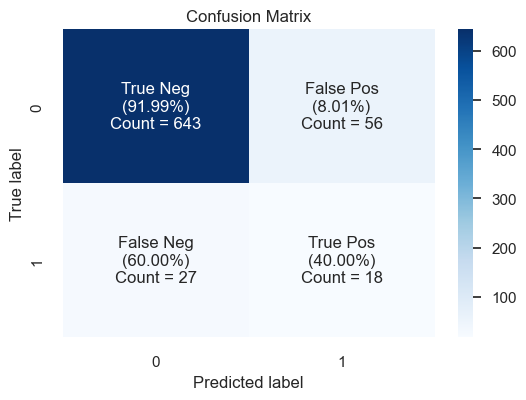

In [83]:
print("Without SMOTE: \n")
# define model
model = svm.SVC(kernel='rbf')
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

svm = svm.SVC(kernel='rbf')
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', svm)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


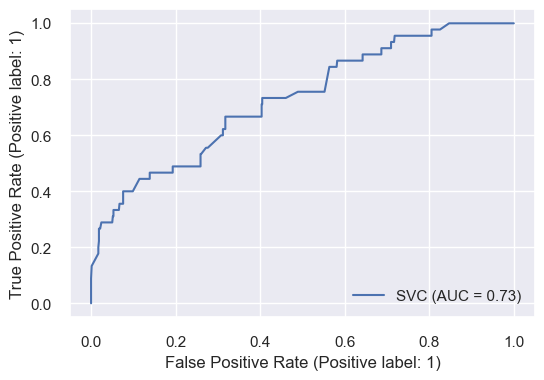

In [84]:
svm_disp = plot_roc_curve(svm, xx_test, yy_test)

## Voting Classifier: Sex

In [85]:
#test the three models with the test data and print their accuracy scores
print('knn: {}'.format(knn_best_sex.score(xx_test, yy_test.Sex)))
print('rf: {}'.format(rf_best_sex.score(xx_test, yy_test.Sex)))
print('log_reg: {}'.format(log_reg_sex.score(xx_test, yy_test.Sex)))

knn: 0.9408602150537635
rf: 0.9422043010752689
log_reg: 0.9408602150537635


### Simple Ensemble

In [86]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('knn', knn_best_sex), ('rf', rf_best_sex), ('log_reg', log_reg_sex)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(xx_train, yy_train['Sex'])
#test our model on the test data
print(ensemble.score(xx_test, yy_test.Sex))

yy_pred = ensemble.predict(xx_test).round()# print classification report
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

0.9408602150537635
Accuracy: 0.9408602150537635


### Ensemble with and without SMOTE

Without SMOTE: 

Mean ROC AUC: nan
Accuracy: 0.9408602150537635
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       699
           1       1.00      0.02      0.04        45

    accuracy                           0.94       744
   macro avg       0.97      0.51      0.51       744
weighted avg       0.94      0.94      0.91       744



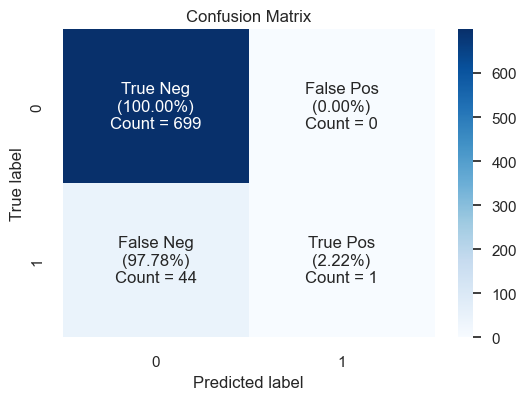

SMOTE: 

Mean ROC AUC: nan
Accuracy: 0.8709677419354839
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       699
           1       0.21      0.40      0.27        45

    accuracy                           0.87       744
   macro avg       0.58      0.65      0.60       744
weighted avg       0.91      0.87      0.89       744



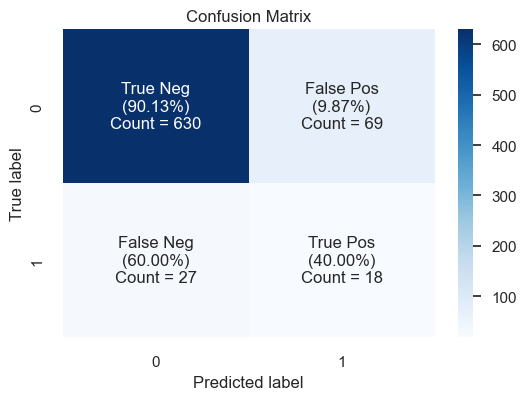

In [87]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('knn', knn_best_sex), ('rf', rf_best_sex), ('log_reg', log_reg_sex)]


print("Without SMOTE: \n")
# define model
model = VotingClassifier(estimators, voting='hard')
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

ensemble = VotingClassifier(estimators, voting='hard')
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', ensemble)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

In [88]:
# ensemble_disp = plot_roc_curve(ensemble, xx_test, yy_test)

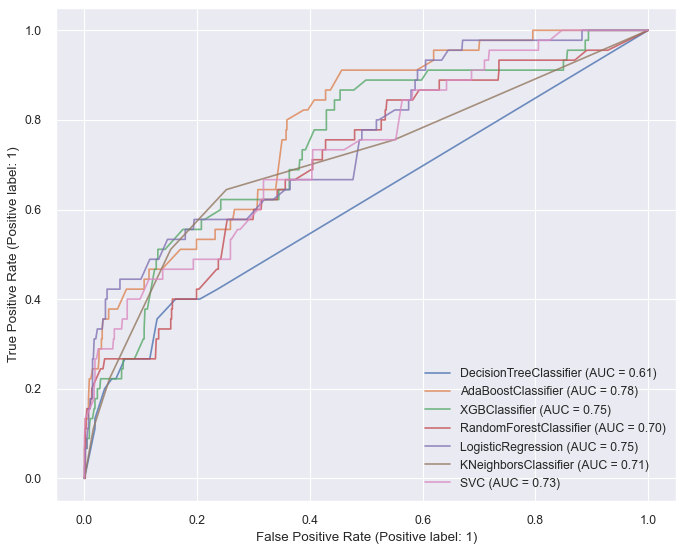

In [89]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
ax = plt.gca()
dtc_disp.plot(ax=ax, alpha=0.8)
ada_disp.plot(ax=ax, alpha=0.8)
xg_disp.plot(ax=ax, alpha=0.8)
rf_disp.plot(ax=ax, alpha=0.8)
logit_disp.plot(ax=ax, alpha=0.8)
knn_disp.plot(ax=ax, alpha=0.8)
svm_disp.plot(ax=ax, alpha=0.8)
#ensemble_disp.plot(ax=ax, alpha=0.8)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is dep

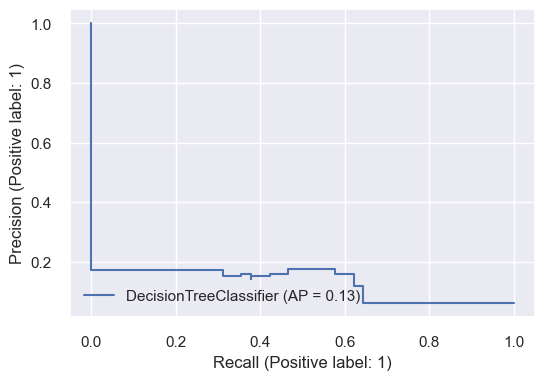

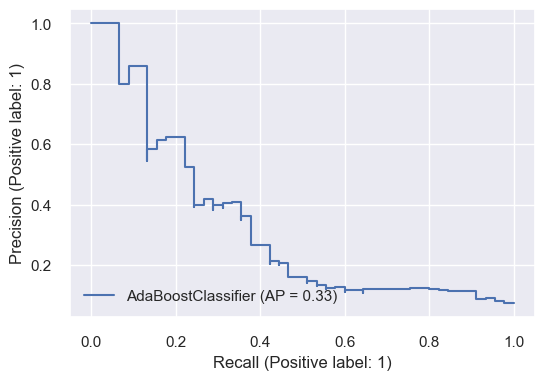

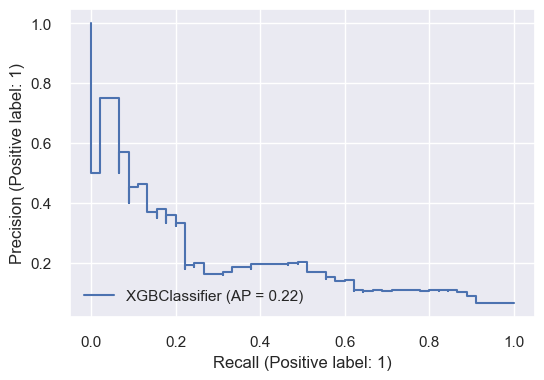

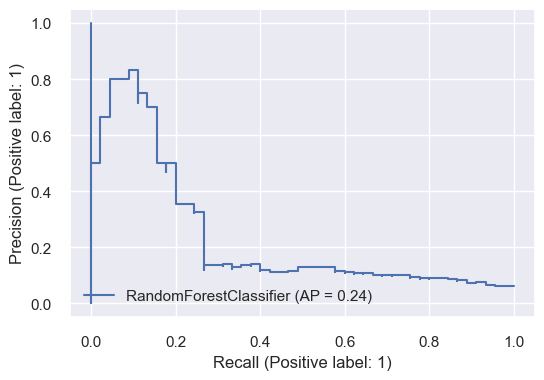

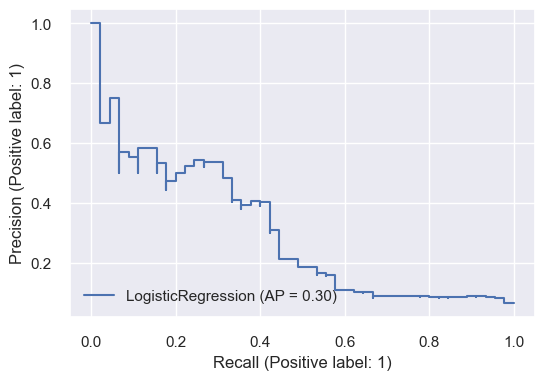

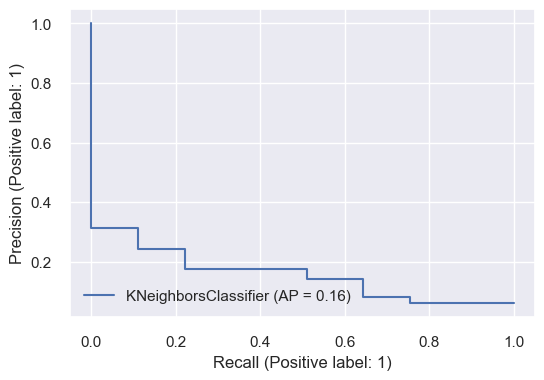

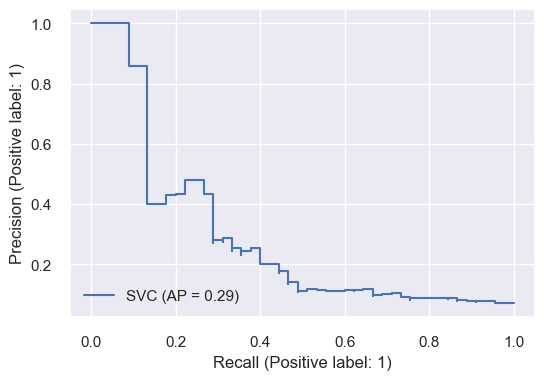

In [90]:
dtc_disp = plot_precision_recall_curve(dtc, xx_test, yy_test)
ada_disp = plot_precision_recall_curve(ada, xx_test, yy_test)
xg_disp = plot_precision_recall_curve(xg, xx_test, yy_test)
rf_disp = plot_precision_recall_curve(rf, xx_test, yy_test)
logit_disp = plot_precision_recall_curve(logit, xx_test, yy_test)
knn_disp = plot_precision_recall_curve(knn, xx_test, yy_test)
svm_disp = plot_precision_recall_curve(svm, xx_test, yy_test)

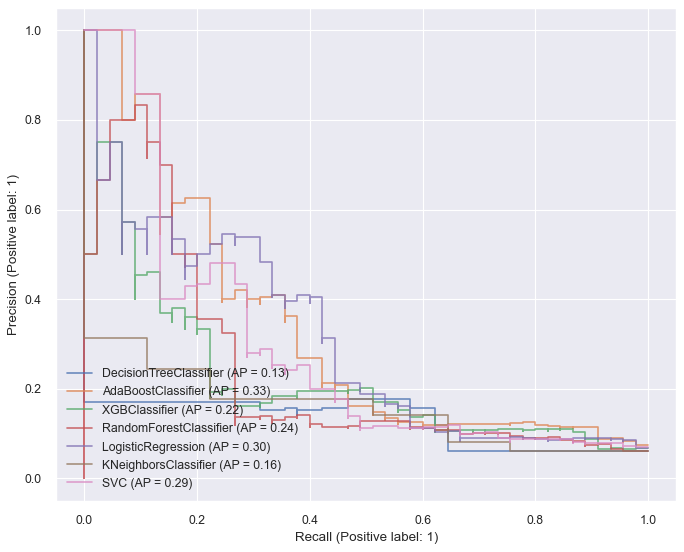

In [91]:
figure(figsize=(10, 8), dpi=80)
ax = plt.gca()
dtc_disp.plot(ax=ax, alpha=0.8)
ada_disp.plot(ax=ax, alpha=0.8)
xg_disp.plot(ax=ax, alpha=0.8)
rf_disp.plot(ax=ax, alpha=0.8)
logit_disp.plot(ax=ax, alpha=0.8)
knn_disp.plot(ax=ax, alpha=0.8)
svm_disp.plot(ax=ax, alpha=0.8)

## Neural Network

In [92]:
import tensorflow as tf
print(tf.__version__)

2.5.0


### NN without SMOTE

In [93]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(2, activation="sigmoid")
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model.fit(xx_train, 
                    tf.one_hot(yy_train['Sex'], depth=2),
                       epochs=100,
                       validation_data=(xx_test, tf.one_hot(yy_test['Sex'], depth=2)))

Epoch 1/100
55/55 [==============================] - 1s 4ms/step - loss: 0.2499 - accuracy: 0.9389 - val_loss: 0.2266 - val_accuracy: 0.9395
Epoch 2/100
55/55 [==============================] - 0s 2ms/step - loss: 0.2106 - accuracy: 0.9389 - val_loss: 0.2035 - val_accuracy: 0.9395
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 0.2062 - accuracy: 0.9389 - val_loss: 0.1955 - val_accuracy: 0.9395
Epoch 4/100
55/55 [==============================] - 0s 2ms/step - loss: 0.2084 - accuracy: 0.9389 - val_loss: 0.1937 - val_accuracy: 0.9395
Epoch 5/100
55/55 [==============================] - 0s 3ms/step - loss: 0.1940 - accuracy: 0.9389 - val_loss: 0.2177 - val_accuracy: 0.9395
Epoch 6/100
55/55 [==============================] - 0s 2ms/step - loss: 0.1998 - accuracy: 0.9389 - val_loss: 0.1950 - val_accuracy: 0.9395
Epoch 7/100
55/55 [==============================] - 0s 2ms/step - loss: 0.1909 - accuracy: 0.9389 - val_loss: 0.1974 - val_accuracy: 0.9395
Epoch 8/100
5

Text(0.5, 1.0, 'Model training curves: Sex')

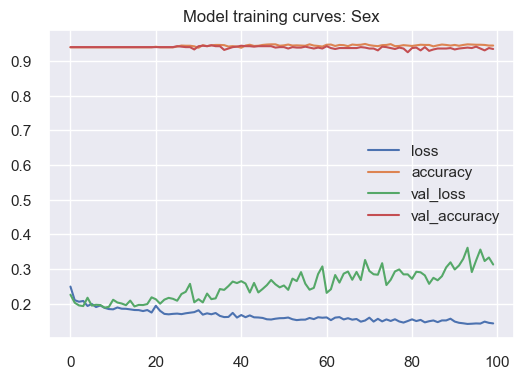

In [94]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model training curves: Sex")

### NN with SMOTE

In [95]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
xx_train_sm, yy_train_sm = sm.fit_resample(xx_train, yy_train.values.ravel())

# Set the random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(2, activation="sigmoid")
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model.fit(xx_train_sm, 
                    tf.one_hot(yy_train_sm, depth=2),
                       epochs=100,
                       validation_data=(xx_test, tf.one_hot(yy_test['Sex'], depth=2)))

Epoch 1/100
102/102 [==============================] - 1s 4ms/step - loss: 0.5149 - accuracy: 0.7463 - val_loss: 0.5745 - val_accuracy: 0.6492
Epoch 2/100
102/102 [==============================] - 0s 2ms/step - loss: 0.4084 - accuracy: 0.8108 - val_loss: 0.3029 - val_accuracy: 0.8952
Epoch 3/100
102/102 [==============================] - 0s 2ms/step - loss: 0.4172 - accuracy: 0.8022 - val_loss: 0.4029 - val_accuracy: 0.7944
Epoch 4/100
102/102 [==============================] - 0s 2ms/step - loss: 0.3854 - accuracy: 0.8166 - val_loss: 0.5040 - val_accuracy: 0.6976
Epoch 5/100
102/102 [==============================] - 0s 2ms/step - loss: 0.3685 - accuracy: 0.8323 - val_loss: 0.3842 - val_accuracy: 0.8347
Epoch 6/100
102/102 [==============================] - 0s 2ms/step - loss: 0.3564 - accuracy: 0.8449 - val_loss: 0.3245 - val_accuracy: 0.8589
Epoch 7/100
102/102 [==============================] - 0s 2ms/step - loss: 0.3447 - accuracy: 0.8443 - val_loss: 0.3430 - val_accuracy: 0.8602

Text(0.5, 1.0, 'Model training curves: SMOTE Sex')

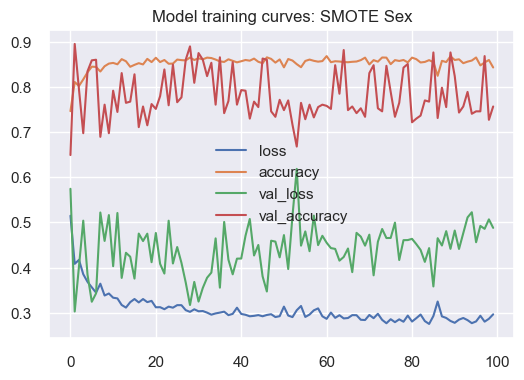

In [96]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model training curves: SMOTE Sex")

# Predicting Race

In [97]:
'''
Run this cell before running any prediction for Race
'''

# separate into training and testing set
n_test = 2
X = df[df.columns[:-n_test]]
y = df[['Race']]
xx_train,xx_test, yy_train, yy_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state=0)

xx_train.shape, yy_train.shape, xx_test.shape, yy_test.shape

((1734, 28), (1734, 1), (744, 28), (744, 1))

## Random Forest

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

### Simple Random Forest

In [99]:
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200, 500, 1000]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(xx_train, yy_train['Race'])
#save best model
rf_best_race = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
n_estimators = rf_gs.best_params_.get('n_estimators')

# Instantiate model with 1000 decision trees
rf_race = RandomForestRegressor(n_estimators = n_estimators, random_state = 42)
# Train the model on training data
rf_race.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = rf_race.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

{'n_estimators': 1000}
Accuracy: 0.696236559139785


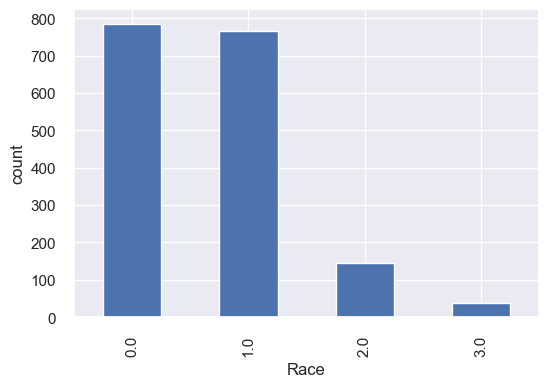

In [100]:
plot_distribution(yy_train, column ='Race')

In [101]:
yy_train.value_counts()

Race
0.0     785
1.0     766
2.0     144
3.0      39
dtype: int64

### Random Forest Classifier with and without SMOTE

In [102]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

Without SMOTE: 

Train Mean ROC AUC: nan
Accuracy: 0.7150537634408602
              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76       337
         1.0       0.73      0.75      0.74       329
         2.0       0.41      0.26      0.32        61
         3.0       0.50      0.06      0.11        17

    accuracy                           0.72       744
   macro avg       0.59      0.47      0.48       744
weighted avg       0.70      0.72      0.70       744

SMOTE: 

Train Mean ROC AUC: nan
Accuracy: 0.6384408602150538
              precision    recall  f1-score   support

         0.0       0.80      0.66      0.73       337
         1.0       0.74      0.67      0.70       329
         2.0       0.21      0.44      0.28        61
         3.0       0.09      0.18      0.12        17

    accuracy                           0.64       744
   macro avg       0.46      0.49      0.46       744
weighted avg       0.71      0.64      0.67       744

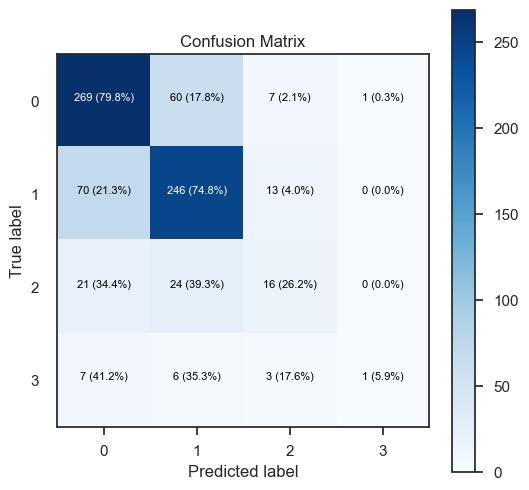

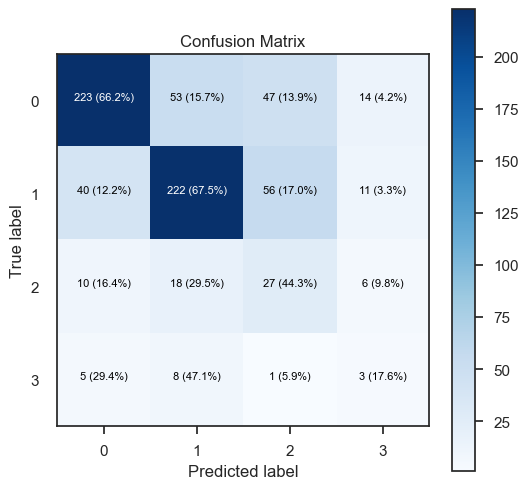

In [103]:
print("Without SMOTE: \n")
# define model
model = RandomForestClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = RandomForestClassifier()
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

### Decision Tree Classifier with and without SMOTE

In [104]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

Without SMOTE: 

Train Mean ROC AUC: nan
Test Accuracy: 0.7083333333333334
              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       337
         1.0       0.72      0.76      0.74       329
         2.0       0.40      0.28      0.33        61
         3.0       0.50      0.12      0.19        17

    accuracy                           0.71       744
   macro avg       0.59      0.48      0.50       744
weighted avg       0.70      0.71      0.70       744

SMOTE: 

Train Mean ROC AUC: nan
Test Accuracy: 0.6008064516129032
              precision    recall  f1-score   support

         0.0       0.76      0.66      0.71       337
         1.0       0.72      0.60      0.66       329
         2.0       0.20      0.41      0.27        61
         3.0       0.04      0.12      0.06        17

    accuracy                           0.60       744
   macro avg       0.43      0.45      0.42       744
weighted avg       0.68      0.60      0.63

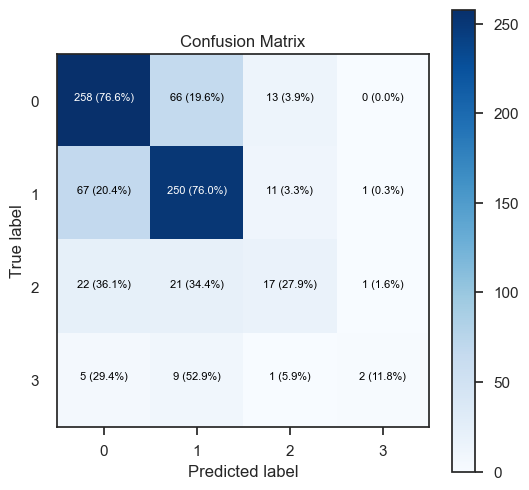

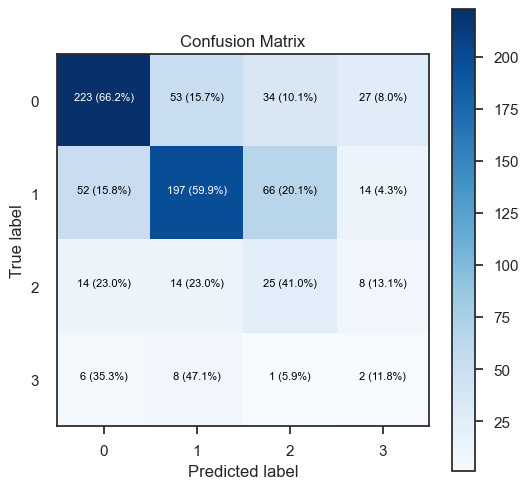

In [105]:
print("Without SMOTE: \n")
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))


# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = DecisionTreeClassifier()
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))


# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## Logistic Regression

In [106]:
from sklearn.linear_model import LogisticRegression

In [107]:
# all parameters not specified are set to their defaults
log_reg_race = LogisticRegression(random_state=42, multi_class='multinomial')
log_reg_race.fit(xx_train, yy_train['Race'])
yy_pred = log_reg_race.predict(xx_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

Accuracy: 0.6317204301075269


C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [108]:
from sklearn import linear_model
from sklearn import model_selection

In [109]:
log_reg_race = linear_model.LogisticRegression(multi_class='multinomial')
log_reg_race.fit(xx_train, yy_train['Race'])
yy_pred = log_reg_race.predict(xx_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

Accuracy: 0.6317204301075269


C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [110]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

Without SMOTE: 

Train Mean ROC AUC: nan
Accuracy: 0.6290322580645161
              precision    recall  f1-score   support

         0.0       0.65      0.70      0.67       337
         1.0       0.61      0.71      0.65       329
         2.0       0.00      0.00      0.00        61
         3.0       0.00      0.00      0.00        17

    accuracy                           0.63       744
   macro avg       0.31      0.35      0.33       744
weighted avg       0.56      0.63      0.59       744

SMOTE: 



C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Mean ROC AUC: nan
Accuracy: 0.4489247311827957
              precision    recall  f1-score   support

         0.0       0.70      0.61      0.65       337
         1.0       0.58      0.34      0.43       329
         2.0       0.12      0.20      0.15        61
         3.0       0.04      0.35      0.07        17

    accuracy                           0.45       744
   macro avg       0.36      0.37      0.32       744
weighted avg       0.59      0.45      0.50       744



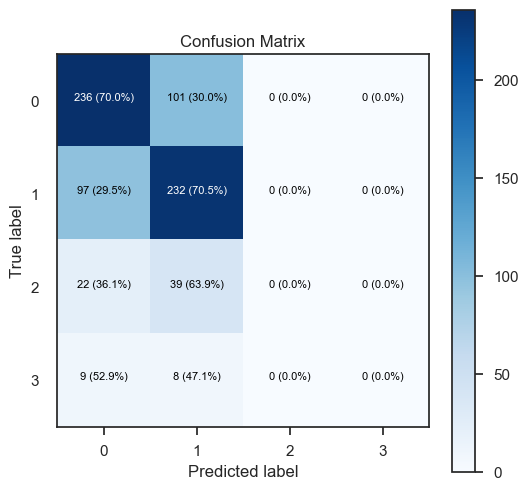

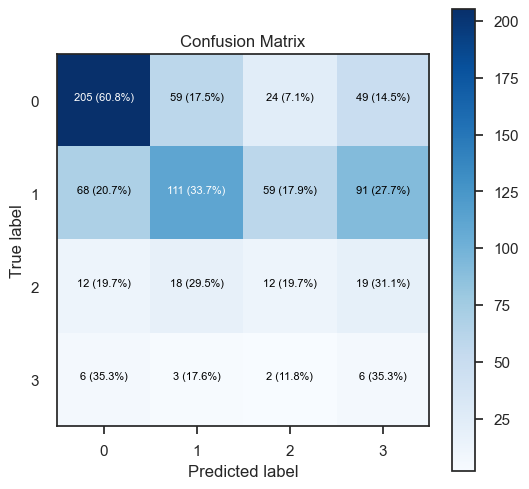

In [111]:
print("Without SMOTE: \n")
# define model
model = LogisticRegression(max_iter=1000, multi_class='multinomial')
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = LogisticRegression(max_iter=1000, multi_class='multinomial')
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## XGBoost

In [112]:
from xgboost import XGBClassifier

In [113]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

Without SMOTE: 

Train Mean ROC AUC: nan
Accuracy: 0.728494623655914
              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77       337
         1.0       0.73      0.78      0.75       329
         2.0       0.55      0.26      0.36        61
         3.0       1.00      0.12      0.21        17

    accuracy                           0.73       744
   macro avg       0.76      0.49      0.52       744
weighted avg       0.73      0.73      0.71       744

SMOTE: 

Train Mean ROC AUC: nan
Accuracy: 0.6451612903225806
              precision    recall  f1-score   support

         0.0       0.76      0.72      0.74       337
         1.0       0.74      0.62      0.67       329
         2.0       0.27      0.48      0.34        61
         3.0       0.07      0.18      0.11        17

    accuracy                           0.65       744
   macro avg       0.46      0.50      0.47       744
weighted avg       0.70      0.65      0.67       744


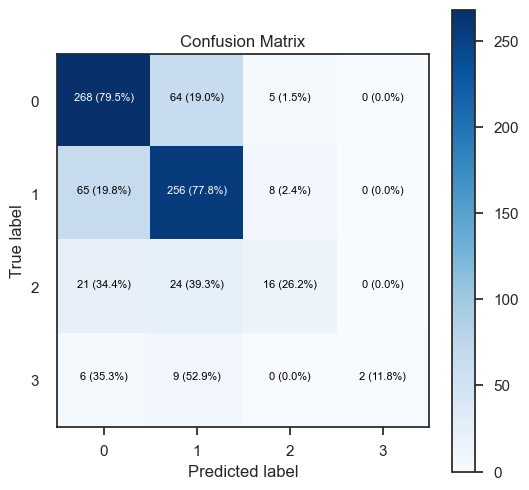

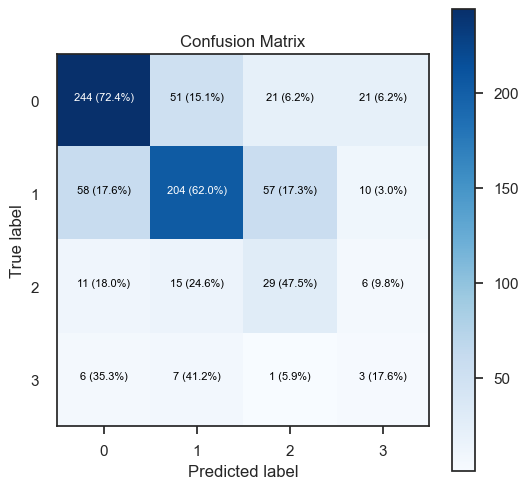

In [114]:
print("Without SMOTE: \n")
# define model
model = XGBClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = XGBClassifier()
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## AdaBoost

In [115]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

### Simple AdaBoost

In [116]:
# Instantiate model with 1000 decision trees
ada_race = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1, random_state = 42)
# Train the model on training data
ada_race.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = ada_race.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

Accuracy: 0.553763440860215


In [117]:
ada_race = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1.5,
    algorithm="SAMME", random_state = 42)
# Train the model on training data
ada_race.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = ada_race.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

Accuracy: 0.75


### AdaBoost with and without SMOTE

In [118]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

Without SMOTE: 

Train Mean ROC AUC: nan
Accuracy: 0.7553763440860215
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79       337
         1.0       0.77      0.80      0.78       329
         2.0       0.70      0.31      0.43        61
         3.0       0.14      0.06      0.08        17

    accuracy                           0.76       744
   macro avg       0.59      0.50      0.52       744
weighted avg       0.74      0.76      0.74       744

SMOTE: 

Train Mean ROC AUC: nan
Accuracy: 0.5806451612903226
              precision    recall  f1-score   support

         0.0       0.80      0.62      0.70       337
         1.0       0.80      0.58      0.67       329
         2.0       0.26      0.43      0.32        61
         3.0       0.04      0.35      0.07        17

    accuracy                           0.58       744
   macro avg       0.48      0.49      0.44       744
weighted avg       0.74      0.58      0.64       744

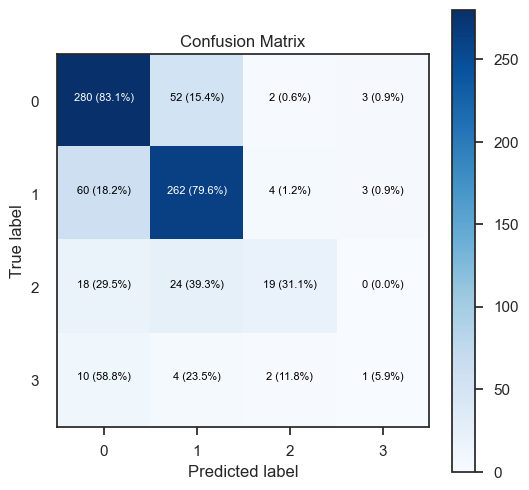

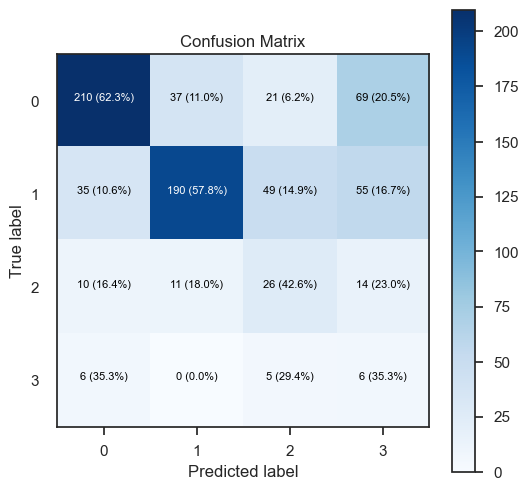

In [119]:
print("Without SMOTE: \n")
# define model
model = AdaBoostClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = AdaBoostClassifier()
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## KNN

In [120]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

### Simple KNN

In [121]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(xx_train, yy_train['Race'])

#save best model
knn_best_race = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)
n_neighbors = knn_gs.best_params_.get('n_neighbors')

knn_race = KNeighborsClassifier(n_neighbors=n_neighbors)

# Train the model on training data
knn_race.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = knn_race.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

{'n_neighbors': 12}
Accuracy: 0.7043010752688172


### KNN with and without SMOTE

In [122]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

Without SMOTE: 

Train Mean ROC AUC: nan
Test Accuracy: 0.7043010752688172
              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75       337
         1.0       0.70      0.74      0.72       329
         2.0       0.56      0.16      0.25        61
         3.0       0.00      0.00      0.00        17

    accuracy                           0.70       744
   macro avg       0.49      0.43      0.43       744
weighted avg       0.68      0.70      0.68       744

SMOTE: 



C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Mean ROC AUC: nan
Test Accuracy: 0.5241935483870968
              precision    recall  f1-score   support

         0.0       0.76      0.49      0.59       337
         1.0       0.74      0.59      0.66       329
         2.0       0.17      0.46      0.25        61
         3.0       0.05      0.29      0.08        17

    accuracy                           0.52       744
   macro avg       0.43      0.46      0.39       744
weighted avg       0.69      0.52      0.58       744



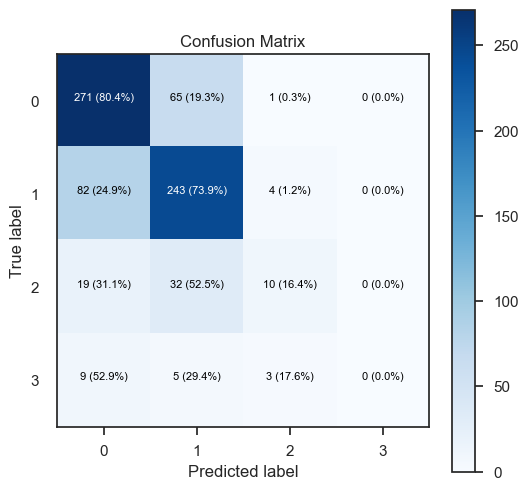

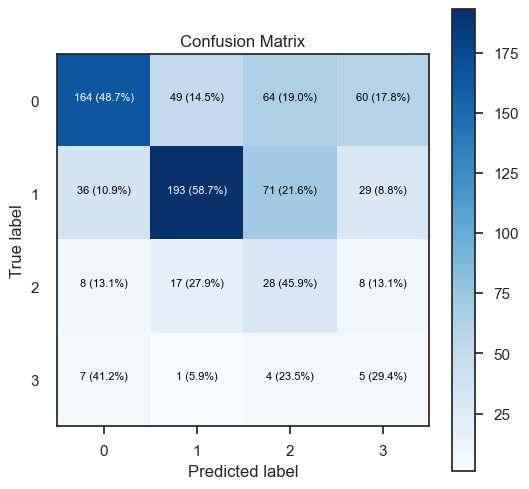

In [123]:
print("Without SMOTE: \n")
# define model
model = KNeighborsClassifier(n_neighbors=n_neighbors)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = KNeighborsClassifier(n_neighbors=n_neighbors)
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## SVM

In [124]:
from sklearn import svm

Without SMOTE: 

Train Mean ROC AUC: nan
Accuracy: 0.5967741935483871
              precision    recall  f1-score   support

         0.0       0.64      0.59      0.62       337
         1.0       0.56      0.74      0.64       329
         2.0       0.00      0.00      0.00        61
         3.0       0.00      0.00      0.00        17

    accuracy                           0.60       744
   macro avg       0.30      0.33      0.31       744
weighted avg       0.54      0.60      0.56       744

SMOTE: 



C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Mean ROC AUC: nan
Accuracy: 0.4206989247311828
              precision    recall  f1-score   support

         0.0       0.69      0.55      0.62       337
         1.0       0.51      0.31      0.39       329
         2.0       0.11      0.31      0.17        61
         3.0       0.04      0.24      0.07        17

    accuracy                           0.42       744
   macro avg       0.34      0.35      0.31       744
weighted avg       0.55      0.42      0.47       744



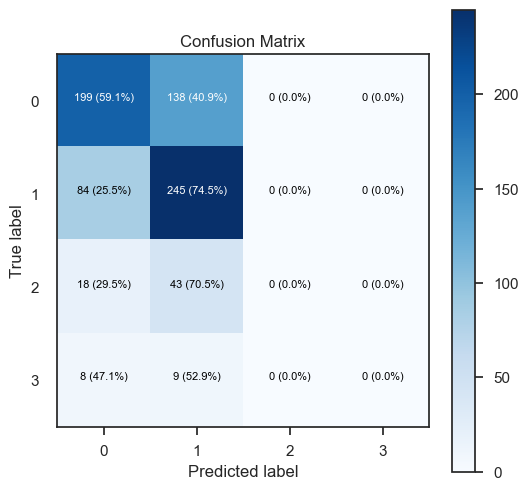

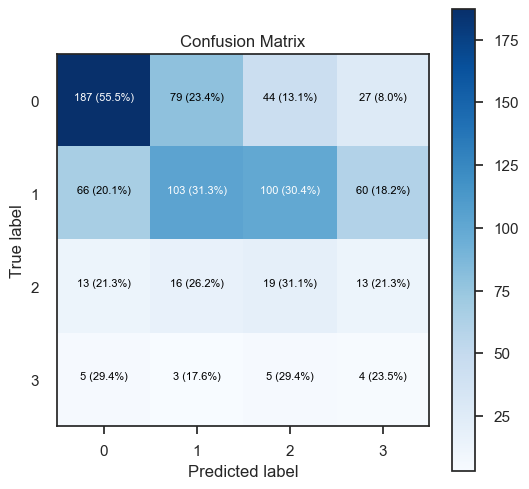

In [125]:
print("Without SMOTE: \n")
# define model
model = svm.SVC(kernel='linear')
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = svm.SVC(kernel='linear')
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## Voting Classifier: Race

In [126]:
from sklearn.ensemble import VotingClassifier

In [127]:
#test the three models with the test data and print their accuracy scores
print('knn: {}'.format(knn_best_race.score(xx_test, yy_test.Race)))
print('rf: {}'.format(rf_best_race.score(xx_test, yy_test.Race)))
print('log_reg: {}'.format(log_reg_race.score(xx_test, yy_test.Race)))

#create a dictionary of our models
estimators=[('knn', knn_best_race), ('rf', rf_best_race), ('log_reg', log_reg_race)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(xx_train, yy_train['Race'])
#test our model on the test data
ensemble.score(xx_test, yy_test.Race)

knn: 0.7043010752688172
rf: 0.7217741935483871
log_reg: 0.6317204301075269


C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.7298387096774194

### Ensemble with and without SMOTE

In [128]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

Without SMOTE: 

Train Mean ROC AUC: nan


C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.7298387096774194
              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77       337
         1.0       0.72      0.80      0.76       329
         2.0       0.73      0.13      0.22        61
         3.0       0.00      0.00      0.00        17

    accuracy                           0.73       744
   macro avg       0.55      0.43      0.44       744
weighted avg       0.71      0.73      0.70       744

SMOTE: 



C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Mean ROC AUC: nan


C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.614247311827957
              precision    recall  f1-score   support

         0.0       0.76      0.69      0.72       337
         1.0       0.76      0.60      0.67       329
         2.0       0.22      0.41      0.28        61
         3.0       0.03      0.12      0.05        17

    accuracy                           0.61       744
   macro avg       0.44      0.45      0.43       744
weighted avg       0.70      0.61      0.65       744



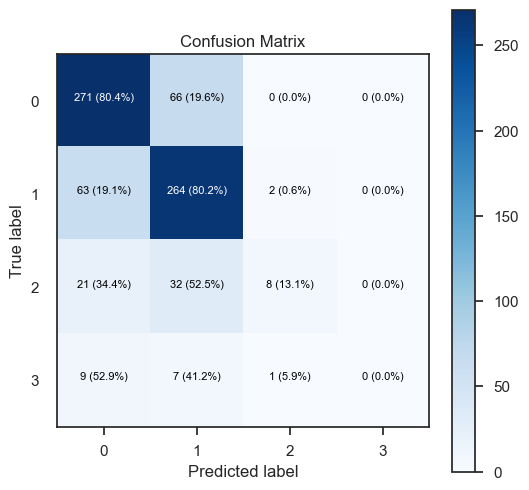

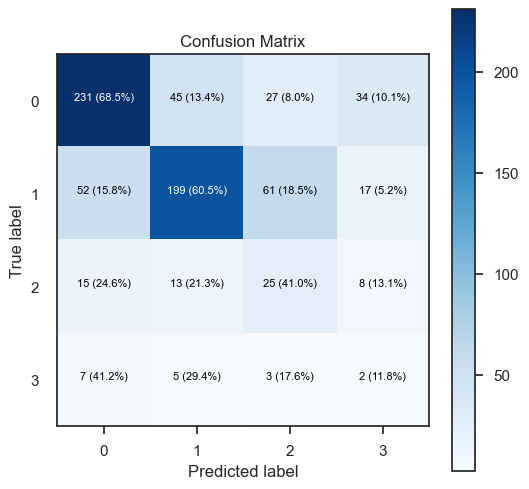

In [129]:
#create a dictionary of our models
estimators=[('knn', knn_best_race), ('rf', rf_best_race), ('log_reg', log_reg_race)]
#create our voting classifier, inputting our models
model = VotingClassifier(estimators, voting='hard')

print("Without SMOTE: \n")
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = VotingClassifier(estimators, voting='hard')
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## Neural Network

In [130]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [131]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="ReLU"),
  tf.keras.layers.Dense(10, activation="ReLU"),
  tf.keras.layers.Dense(10, activation="ReLU"),
  tf.keras.layers.Dense(10, activation="ReLU"),
  tf.keras.layers.Dense(4, activation="softmax")
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model.fit(xx_train, 
                    tf.one_hot(yy_train['Race'], depth=4),
                       epochs=100,
                       validation_data=(xx_test, tf.one_hot(yy_test['Race'], depth=4)))

Epoch 1/100
55/55 [==============================] - 1s 7ms/step - loss: 1.0109 - accuracy: 0.5779 - val_loss: 0.8718 - val_accuracy: 0.6935
Epoch 2/100
55/55 [==============================] - 0s 4ms/step - loss: 0.8633 - accuracy: 0.6742 - val_loss: 0.8522 - val_accuracy: 0.6519
Epoch 3/100
55/55 [==============================] - 0s 3ms/step - loss: 0.8146 - accuracy: 0.6886 - val_loss: 0.7742 - val_accuracy: 0.7151
Epoch 4/100
55/55 [==============================] - 0s 3ms/step - loss: 0.7773 - accuracy: 0.7013 - val_loss: 0.7648 - val_accuracy: 0.7177
Epoch 5/100
55/55 [==============================] - 0s 3ms/step - loss: 0.7431 - accuracy: 0.7111 - val_loss: 0.7607 - val_accuracy: 0.7191
Epoch 6/100
55/55 [==============================] - 0s 3ms/step - loss: 0.7405 - accuracy: 0.7163 - val_loss: 0.7416 - val_accuracy: 0.7218
Epoch 7/100
55/55 [==============================] - 0s 3ms/step - loss: 0.7213 - accuracy: 0.7209 - val_loss: 0.7577 - val_accuracy: 0.7258
Epoch 8/100
5

Text(0.5, 1.0, 'Model training curves: Race')

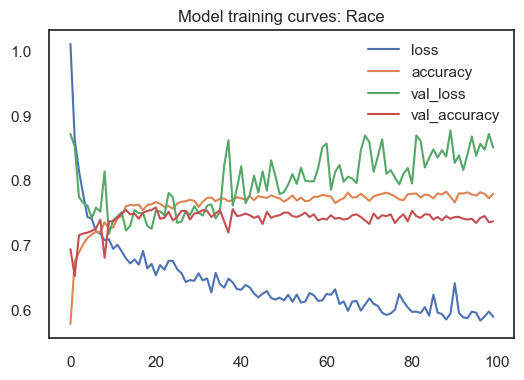

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\joblib\_memmapping_reducer.py:608: UserWarning: Failed to delete temporary folder: C:\Users\yudhi\AppData\Local\Temp\joblib_memmapping_folder_15164_3d9bde5e09264c729d964cb27db30c7c_c61e14a1f82e4bf7b33d06438fe47c19
  .format(pool_subfolder))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\joblib\_memmapping_reducer.py:608: UserWarning: Failed to delete temporary folder: C:\Users\yudhi\AppData\Local\Temp\joblib_memmapping_folder_15164_331918465d4a4696b0252629dcd7b1e9_95a94e31193e4b48b106cfa5e23e0911
  .format(pool_subfolder))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\joblib\_memmapping_reducer.py:608: UserWarning: Failed to delete temporary folder: C:\Users\yudhi\AppData\Local\Temp\joblib_memmapping_folder_15164_3d9bde5e09264c729d964cb27db30c7c_5f25a9e1895f461ab9b0dbc6d07382bb
  .format(pool_subfolder))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\joblib\_memmapping_reducer.py:608: UserWarning: Failed to

In [132]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model training curves: Race")